In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

import target_predicting_ML_functions_and_feature_ranking as functions
import RF_target_predicting_and_learning_curves_functions as tp_lc_functions

In [2]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as cons


def Delta(z,Om0=0.279,Ob0=0.046,h=0.7):
    #Bryan & Norman 99
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    x=cosmo.Om(z)-1
    return 18*np.pi**2+82*x-39*x**2

def rho_crit(z,Om0=0.279,Ob0=0.046,h=0.7):
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    return cosmo.critical_density(z).to(u.Msun/u.kpc**3).value

def rho_vir(z,Om0=0.279,Ob0=0.046,h=0.7):
    D=Delta(z,Om0=Om0,Ob0=Ob0,h=h)
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    rho_c = cosmo.critical_density(z).to(u.Msun/u.kpc**3).value
    return D*rho_c

def Rvir_to_Mvir(Rvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return rho_v*4./3.*np.pi*Rvir**3   #Msun

def Mvir_to_Rvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return  (Mvir/(rho_v*4./3.*np.pi))**(1./3.)  #kpc

def Mvir_to_Vvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    Rvir = Mvir_to_Rvir(Mvir,z,Om0=Om0,Ob0=Ob0,h=h)
    return (np.sqrt(cons.G*Mvir*u.Msun/(Rvir*u.kpc))).to(u.km/u.s)

In [216]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel(r"$R^{2}$ score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

#### Normalized Dataset

In [4]:
# Normalized dataset: all masses divided by halo mass (Mvir)
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

# Remove non-physical galaxies whose Mstar/Mvir (GalpropNormMstar) > 0.2
df_normalized_31 = df_normalized_31[df_normalized_31.GalpropNormMstar < 0.2]

In [5]:
# Add BulgeMstar ratio and its corresponding quantities in order to use them in the physical formula

df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']
df_normalized_31.loc[:, 'GalpropNormMdisk'] = df_normalized_31.loc[:, 'GalpropNormMstar'] - df_normalized_31.loc[:, 'GalpropNormMbulge']
df_normalized_31.loc[:, 'DiskMstar_ratio']  = df_normalized_31.loc[:, 'GalpropNormMdisk']/df_normalized_31.loc[:, 'GalpropNormMstar']

#### Not-Normalized Dataset (Raw)

In [6]:
# df here read from the data filtered file from notebook v5
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') 

# Raw dataset
df_not_normalized = df_log_mass_filtered_v5.loc[: , :]

# Define Halo property Vvir (as it does not exist in the dataset above)
v= Mvir_to_Vvir (np.array(df_not_normalized.loc[:,'HalopropMvir']),0) # has units

# add Halo property Vvir
df_not_normalized.loc[:, 'HalopropVvir']=v.value 

# Remove non-physical galaxies whose Mstar/Mvir > 0.2
df_not_normalized.loc[: , 'MstarMvir_ratio'] = df_not_normalized.loc[:, 'GalpropMstar']/df_not_normalized.loc[:, 'GalpropMvir']

df_not_normalized = df_not_normalized[df_not_normalized.MstarMvir_ratio < 0.2]

In [7]:
# Add BulgeMstar ratio and its corresponding quantities in order to use them in the physical formula

df_not_normalized.loc[:, 'BulgeMstar_ratio'] = df_not_normalized.loc[:,'GalpropMbulge']/df_not_normalized.loc[:, 'GalpropMstar']
df_not_normalized.loc[:, 'GalpropMdisk'] = df_not_normalized.loc[:, 'GalpropMstar'] - df_not_normalized.loc[:, 'GalpropMbulge']
df_not_normalized.loc[:, 'DiskMstar_ratio']  = df_not_normalized.loc[:, 'GalpropMdisk']/df_not_normalized.loc[:, 'GalpropMstar']

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


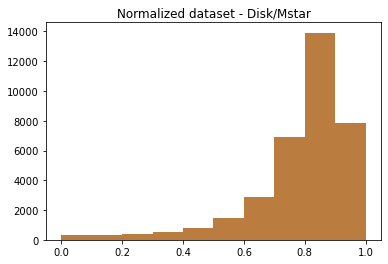

In [8]:
plt.hist(df_normalized_31['DiskMstar_ratio'])
plt.hist(df_not_normalized['DiskMstar_ratio'], alpha=0.7)

plt.title('Normalized dataset - Disk/Mstar')
plt.show()

Note: From here on, only the normalized dataset is used for analysis.

## <font color='purple'> <a id =2> </a> <br> Correlations Matrix

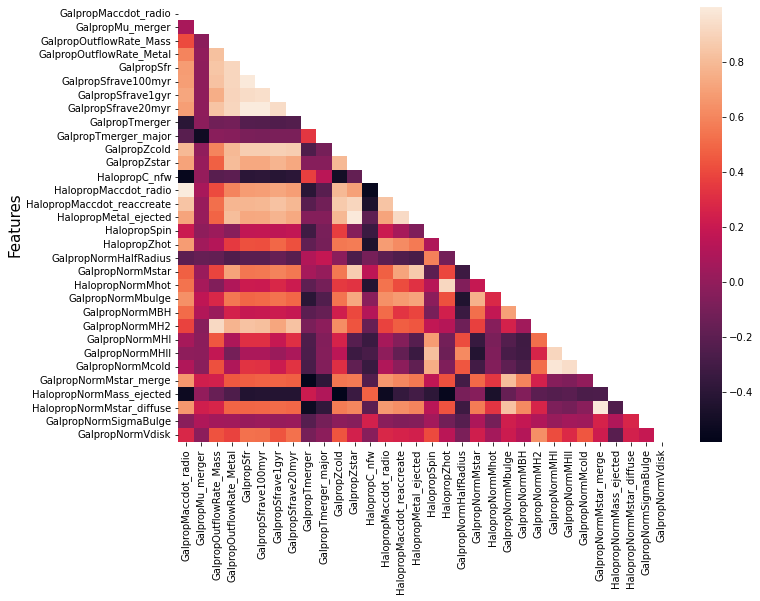

In [6]:
df_sample = df_normalized_31.sample(n = 1000, random_state = 2022)
corr_df = df_sample.corr('spearman')
plt.figure(figsize=(11,8))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, mask=matrix)
# plt.title("Spearman Correlation of TNG-SAM ", fontsize = 20)
plt.ylabel("Features", fontsize = 15)
# plt.savefig('TNG-SAM_Spearman_correlation_matrix_df_normalized_31.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =3> </a> <br> Machine Learning (LR, RF & SVR) results - All morphologies (using the complete dataset)

### Random Forest - RF

In [9]:
X_all = df_normalized_31.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio', 'GalpropNormMdisk', 
                                        'DiskMstar_ratio'])


y_all = df_normalized_31.loc[:,'GalpropNormHalfRadius']

Note: Update the grid to search for best model. Here the already known best model is used (in order to reduce time required to run the line)

In [11]:
regr_RF = RandomForestRegressor(random_state=0)

# number of trees in random forest
n_estimators = [100]
# create random grid
grid = {'bootstrap': [True],
               'max_depth': [None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Re-design the grid using the best params obtained from gridsearchCV on the complete dataset in notebook v19
# Best params, best score: 0.9144 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}

# Grid search of parameters
rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(rfr_grid.best_score_), \
    rfr_grid.best_params_)
# define trainscore according to best model
best_RF=rfr_grid.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

best_RF_trainscore=rfr_grid.cv_results_['mean_train_score'][rfr_grid.best_index_]

# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF = cross_val_predict(best_RF, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))
# y_pred_RF.to_csv('v35_RF_predicted_sizes.csv', index=False)


# find prediction scores of each of the cross validation fold
scores_RF = cross_val_score(best_RF, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print("RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params, best score: 0.9183 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
RF Accuracy: 0.92 (+/- 0.02)


In [13]:
y_pred_RF

array([17.07310539, 16.64136341, 22.20080318, ..., 17.90163324,
       24.95741558, 20.82070646])

In [14]:
y_pred_RF_df = pd.DataFrame({'y_pred_RF': y_pred_RF})

In [15]:
y_pred_RF_df

y_pred_RF
0      17.073105
1      16.641363
2      22.200803
3      23.078693
4      14.717024
...          ...
35363  42.172147
35364  54.025646
35365  17.901633
35366  24.957416
35367  20.820706

[35368 rows x 1 columns]

In [16]:
# y_pred_RF_df.to_csv('v35_y_pred_RF_predicted_sizes.csv', index=False)

#### Distribution of RF predicted sizes vs true sizes

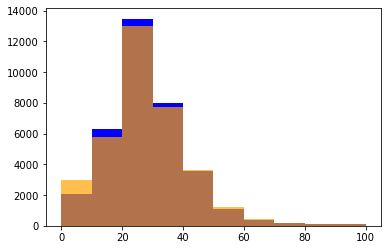

In [26]:
plt.hist(y_pred_RF, color='blue', label='RF predicted sizes', range=(0,100))
plt.hist(df_normalized_31.loc[:, 'GalpropNormHalfRadius'],  color='orange', 
         label='True sizes', alpha=0.7, range=(0,100))
plt.show()

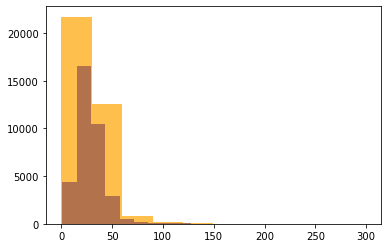

In [27]:
plt.hist(y_pred_RF, color='blue', label='RF predicted sizes')
plt.hist(df_normalized_31.loc[:, 'GalpropNormHalfRadius'],  color='orange', 
         label='True sizes', alpha=0.7)
plt.show()

KeyboardInterrupt: 

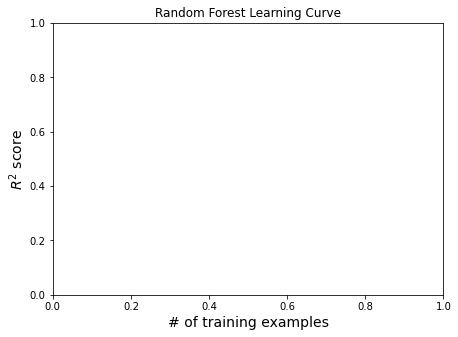

In [217]:
# this code takes ~2.5min to run on the whole dataset with ~35,000 galaxies
start_time = time.time()

lc_all_rf = plot_learning_curve(best_RF, 'RF Learning Curve, Complete Dataset', X_all, y_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_RF_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

### Linear Regression - LR

Note: Update to use the same style like in RF and SVR where cv is applied to all dataset, not just X_test, y_test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

In [11]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.6242560679844421

In [12]:
reg.score(X_test, y_test)

0.6087479154482511

In [13]:
y_pred_LR = cross_val_predict(reg, X_test, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

Elapsed time to run SVR Learning Curves on the complete dataset: 0.299 seconds


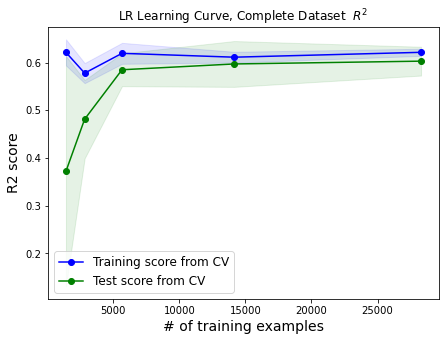

In [14]:
# this code takes ~2.5min to run on the whole dataset with ~35,000 galaxies
start_time = time.time()

lc_all_lr = plot_learning_curve(reg, 'LR Learning Curve, Complete Dataset  $R^{2} $', X_all, y_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

### Support Vector Regressor - SVR

Note: Update the grid to search for best model. Here the already known best model is used (in order to reduce time required to run the line)

In [28]:
# this code takes ~ 1.4 hrs to run it on the complete dataset with ~35,000 galaxies 
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale'], 'svr__C':[1000], \
              }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_all.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on Complete Dataset: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params, best score: 0.9370 {'svr__C': 1000, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on Complete Dataset: 4853.210 seconds


Note: SVR provides an increased R2 score when outlier galaxies are removed (R2 score used to be 0.92, and now is 0.94 after removing the non-physical galaxies.)

In [29]:
best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [30]:
start_time = time.time()
y_pred_SVR_all = cross_val_predict(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print(f"Elapsed time to calculate y_pred_SVR_all with 5-fold CV: {elapsed_time:.3f} seconds")

Elapsed time to calculate y_pred_SVR_all with 5-fold CV: 4853.210 seconds


In [31]:
y_pred_SVR_all_df = pd.DataFrame({'y_pred_SVR_all': y_pred_SVR_all})

# y_pred_SVR_all_df.to_csv('v35_y_pred_SVR_all_predicted_sizes.csv', index=False)

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Elapsed time to run SVR Learning Curves on the complete dataset: 4439.432 seconds


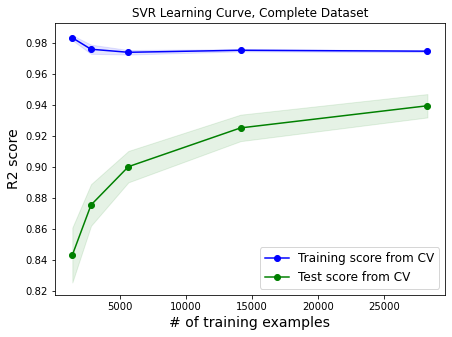

In [18]:
# this code takes ~1,2 hrs to run on the whole dataset with ~35,000 galaxies
start_time = time.time()

lc_all_svr = plot_learning_curve(best_SVR_all, 'SVR Learning Curve, Complete Dataset', X_all, y_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

# <font color='red'> <a id =4> </a> <br> Note: SAVE the predicted arrays for each LR, RF, SVR in csv file!!!

## <font color='purple'> <a id =4> </a> <br> LR, RF, SVR figure

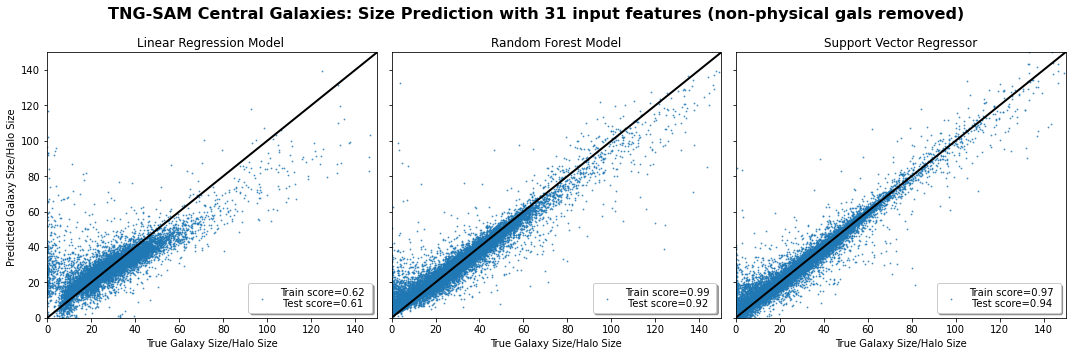

In [20]:
fig1,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
fig1.suptitle('TNG-SAM Central Galaxies: Size Prediction with 31 input features (non-physical gals removed)', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
# print(label)
im1 = ax1.scatter(y_test, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.0,150, 0.0,150])
ax1.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
im5 = ax5.scatter(y_all, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
ax5.axis([0.0,150, 0.0,150])
ax5.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax5.set_title('Random Forest Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_all, 2),round(scores_SVR_all.mean(), 2) )
im6 = ax6.scatter(y_all, y_pred_SVR_all, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.0,150, 0.0,150])
ax6.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax6.set_title('Support Vector Regressor')
ax6.set_xlabel('True Galaxy Size/Halo Size')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig1.tight_layout()
# fig1.savefig("v35_TNG-SAM_LR_RF_SVR_size_prediction_31feat_no_nonphysical_galaxies.jpeg", dpi=500)
plt.show()

### KITP-CCA workshop presentation, Slide 4, "Is the information there?", no color-coding by morphology here because no talking about morphology yet (note for future, color-code ML models by morphology because it becomes obvious that ellipticals are the ones lying on the lower left corner)

In [ ]:
fig1,[ax5, ax6 ]=plt.subplots(nrows=1,ncols=2,sharey=True, figsize=(12,5))
# fig1.suptitle('TNG-SAM Central Galaxies: Size Prediction with 31 input features (non-physical gals removed)', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
# # print(label)
# im1 = ax1.scatter(y_test, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
# # ax1.set_xlim([9.0, 11.5])
# # ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# # ax1.set_ylim([0.2,1.2])
# ax1.axis([0.0,150, 0.0,150])
# ax1.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
# ax1.set_title('Linear Regression Model ')
# ax1.set_xlabel('True Galaxy Size/Halo Size')
# ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
# ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
im5 = ax5.scatter(y_all*1e-3, y_pred_RF*1e-3, s=3, marker='.', alpha=0.7, label=label)
#                     c  = df_normalized_31.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
#                     vmin=0.0, vmax=1.0,label=label) # label=r' $\frac{Mdisk}{Mstar}$ '
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
ax5.axis([0.0,150*1e-3, 0.0,150*1e-3])
ax5.plot([0.0, 170*1e-3], [0.0, 170*1e-3], color = 'black', linewidth = 2)
ax5.set_title('Random Forest Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
ax5.set_ylabel('Predicted Galaxy Size/Halo Size ')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_all, 2),round(scores_SVR_all.mean(), 2) )
im6 = ax6.scatter(y_all*1e-3, y_pred_SVR_all*1e-3, s=3, marker='.', alpha=0.7, label=label)
#                   c  = df_normalized_31.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
#                     vmin=0.0, vmax=1.0,label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.0,150*1e-3, 0.0,150*1e-3])
ax6.plot([0.0, 170*1e-3], [0.0, 170*1e-3], color = 'black', linewidth = 2)
ax6.set_title('Support Vector Regressor')
ax6.set_xlabel('True Galaxy Size/Halo Size')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
# fig1.colorbar(im6, ax=ax6)
# fig1.subplots_adjust(right=0.8)
# cbar_ax = fig1.add_axes([0.85, 0.15, 0.01, 0.7])
# fig1.colorbar(im6, cax=cbar_ax, label=r' $\frac{Mdisk}{Mstar}$')
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

fig1.subplots_adjust(hspace=0.0, wspace=0.07)
# fig1.tight_layout(w_pad=1.0)
# fig1.savefig("v35_TNG-SAM_RF_SVR_size_prediction_31feat_no_nonphysical_galaxies_no_corobar.jpeg", dpi=500)
plt.show()

## <font color='purple'> <a id =4> </a> <br> Feature Ranking: All morphologies, add-on feature ranking using RF model

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.9175 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
RF Accuracy: 0.92 (+/- 0.02)


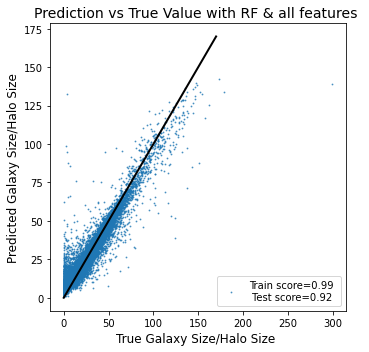

Elapsed time to compute the importances: 0.106 seconds
Elapsed time to compute the importances: 67.798 seconds


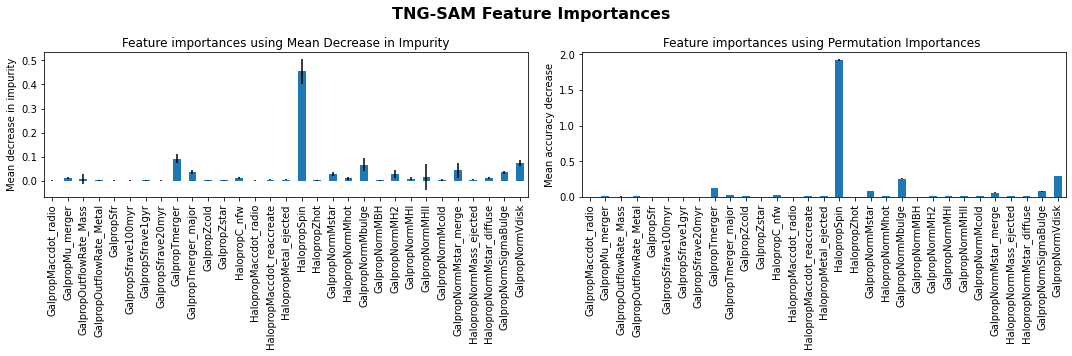

  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/31 [00:02<01:12,  2.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/31 [00:10<02:45,  5.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▎                                       | 3/31 [00:18<03:15,  6.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 4/31 [00:25<03:08,  6.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 5/31 [00:33<03:08,  7.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▌                                   | 6/31 [00:40<02:59,  7.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|█████████▉                                  | 7/31 [00:47<02:52,  7.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▎                                | 8/31 [00:54<02:41,  7.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 9/31 [00:59<02:23,  6.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▊                             | 10/31 [01:04<02:03,  5.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                           | 11/31 [01:12<02:08,  6.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▋                          | 12/31 [01:19<02:09,  6.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████                         | 13/31 [01:30<02:22,  7.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▍                       | 14/31 [01:33<01:48,  6.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 15/31 [01:41<01:52,  7.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 16/31 [01:49<01:50,  7.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▌                   | 17/31 [01:55<01:37,  6.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▉                  | 18/31 [02:03<01:33,  7.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 19/31 [02:11<01:29,  7.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▋               | 20/31 [02:16<01:14,  6.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 21/31 [02:23<01:07,  6.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▌            | 22/31 [02:25<00:47,  5.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▉           | 23/31 [02:32<00:45,  5.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▎         | 24/31 [02:39<00:43,  6.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 25/31 [02:46<00:38,  6.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 26/31 [02:53<00:32,  6.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▍     | 27/31 [02:58<00:25,  6.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▊    | 28/31 [03:06<00:20,  6.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▏  | 29/31 [03:10<00:11,  5.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 30/31 [03:17<00:06,  6.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 31/31 [03:22<00:00,  6.52s/it]


1. iteration: 
	 1 HalopropSpin 0.38981842549718637


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/30 [00:10<05:01, 10.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                         | 2/30 [00:22<05:11, 11.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 3/30 [00:34<05:21, 11.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▊                                      | 4/30 [00:46<05:05, 11.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 5/30 [00:57<04:50, 11.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 6/30 [01:09<04:37, 11.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▎                                 | 7/30 [01:20<04:24, 11.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 8/30 [01:32<04:12, 11.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 9/30 [01:42<03:53, 11.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 10/30 [01:51<03:29, 10.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▊                           | 11/30 [02:04<03:33, 11.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 12/30 [02:16<03:24, 11.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 13/30 [02:27<03:14, 11.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████                       | 14/30 [02:38<03:01, 11.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 15/30 [02:50<02:51, 11.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▉                    | 16/30 [03:02<02:41, 11.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 17/30 [03:13<02:28, 11.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 18/30 [03:24<02:18, 11.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 19/30 [03:37<02:09, 11.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 20/30 [03:48<01:55, 11.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████             | 21/30 [03:59<01:42, 11.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.029, test=0.016) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.043, test=0.011) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.028, test=0.016) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.081, test=0.002) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.485, test=-0.220) total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.078, test=0.070) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.154, test=0.052) total time=   1.2s
[CV 1/3] END bo

 73%|███████████████████████████████▌           | 22/30 [04:12<01:34, 11.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.025, test=0.025) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.039, test=0.018) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.031, test=0.011) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.474, test=-0.226) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.477, test=-0.215) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.081, test=0.067) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.144, test=0.054) total time=   1.2s
[CV 2/3] E

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.025, test=0.024) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.042, test=0.011) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.039, test=0.017) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.042, test=0.018) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.061, test=0.001) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.028, test=0.016) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.028, test=0.016) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimat

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.029, test=0.015) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.026, test=0.021) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.060, test=-0.008) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.028, test=0.016) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.070, test=0.009) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.081, test=0.005) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.077, test=0.069) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=

 77%|████████████████████████████████▉          | 23/30 [04:25<01:24, 12.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.029, test=0.016) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.062, test=-0.007) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.030, test=0.010) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.079, test=0.002) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.074, test=0.010) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.467, test=-0.228) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.489, test=-0.256) total time=   3.5s
[CV 2/3

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.026, test=0.021) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.042, test=0.015) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.043, test=0.011) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.059, test=-0.009) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.061, test=0.001) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.030, test=0.010) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.080, test=0.005) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estima

 80%|██████████████████████████████████▍        | 24/30 [04:37<01:13, 12.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.025, test=0.025) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.042, test=0.017) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.061, test=-0.009) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.061, test=-0.008) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.027, test=0.016) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.078, test=0.006) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.081, test=0.003) total time=   2.0s
[CV 3/3] E

 83%|███████████████████████████████████▊       | 25/30 [04:50<01:01, 12.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▎     | 26/30 [05:01<00:47, 11.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.026, test=0.021) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.039, test=0.017) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.060, test=-0.000) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.063, test=-0.007) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.028, test=0.016) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.075, test=0.011) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.078, test=0.069) total time=   1.3s
[CV 3/3] 

 90%|██████████████████████████████████████▋    | 27/30 [05:12<00:35, 11.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████▏  | 28/30 [05:23<00:22, 11.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 29/30 [05:34<00:11, 11.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 30/30 [05:44<00:00, 11.48s/it]


2. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▌                                          | 1/29 [00:16<07:55, 16.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███                                         | 2/29 [00:34<07:43, 17.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▌                                       | 3/29 [00:51<07:30, 17.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 4/29 [01:09<07:15, 17.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▌                                    | 5/29 [01:26<06:58, 17.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████                                   | 6/29 [01:44<06:41, 17.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 7/29 [02:01<06:22, 17.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 8/29 [02:18<06:05, 17.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▋                              | 9/29 [02:35<05:41, 17.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 10/29 [02:50<05:14, 16.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▎                          | 11/29 [03:08<05:04, 16.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▊                         | 12/29 [03:25<04:50, 17.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▎                       | 13/29 [03:43<04:34, 17.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 14/29 [04:00<04:16, 17.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 15/29 [04:17<04:01, 17.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 16/29 [04:35<03:45, 17.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▏                 | 17/29 [04:52<03:28, 17.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▋                | 18/29 [05:10<03:11, 17.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 66%|████████████████████████████▏              | 19/29 [05:27<02:53, 17.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▋             | 20/29 [05:45<02:36, 17.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████████▏           | 21/29 [06:02<02:19, 17.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▌          | 22/29 [06:20<02:02, 17.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 23/29 [06:38<01:46, 17.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 24/29 [06:56<01:28, 17.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████      | 25/29 [07:14<01:11, 17.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▌    | 26/29 [07:32<00:53, 17.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████   | 27/29 [07:49<00:35, 17.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.528, test=0.495) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.621, test=0.511) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.635, test=0.486) total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.839, test=0.432) total time=   4.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.480, test=0.452) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.573, test=0.443) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.589, test=0.447) total time=   1.8s
[CV 2/3] END b

 97%|█████████████████████████████████████████▌ | 28/29 [08:07<00:17, 17.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.490, test=0.434) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.579, test=0.449) total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.810, test=0.364) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.826, test=0.366) total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.538, test=0.477) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.626, test=0.515) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.636, test=0.478) total time=   3.4s
[CV 1/3] END

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.833, test=0.439) total time=   4.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.520, test=0.512) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.631, test=0.482) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.636, test=0.482) total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.829, test=0.423) total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.831, test=0.463) total time=   4.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.481, test=0.453) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estim

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.476, test=0.457) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.481, test=0.454) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.814, test=0.353) total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.817, test=0.393) total time=   4.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.536, test=0.481) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.832, test=0.419) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.828, test=0.469) total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_esti

100%|███████████████████████████████████████████| 29/29 [08:23<00:00, 17.38s/it]


3. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.473, test=0.480) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.600, test=0.429) total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.813, test=0.376) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.820, test=0.424) total time=   4.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.533, test=0.494) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.639, test=0.463) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.637, test=0.488) total time=   3.5s
[CV 1/3] END

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.520, test=0.512) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.633, test=0.485) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.829, test=0.462) total time=   2.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.490, test=0.433) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.593, test=0.420) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.580, test=0.451) total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.821, test=0.385) total time=   4.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimato

  4%|█▌                                          | 1/28 [00:22<10:17, 22.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▏                                        | 2/28 [00:46<10:05, 23.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.644, test=0.471) total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.831, test=0.468) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.532, test=0.487) total time=   2.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.638, test=0.482) total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.476, test=0.458) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.587, test=0.440) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.601, test=0.422) total time=   3.5s
[CV 1/3] END 

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.839, test=0.431) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.568, test=0.558) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.657, test=0.550) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.849, test=0.484) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.528, test=0.501) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.600, test=0.512) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.615, test=0.490) total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimator

 11%|████▋                                       | 3/28 [01:12<10:12, 24.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▎                                     | 4/28 [01:35<09:33, 23.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 5/28 [01:58<09:05, 23.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▍                                  | 6/28 [02:22<08:39, 23.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 7/28 [02:45<08:14, 23.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 8/28 [03:08<07:49, 23.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████▏                             | 9/28 [03:31<07:21, 23.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▎                           | 10/28 [03:53<06:48, 22.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▉                          | 11/28 [04:16<06:29, 22.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▍                        | 12/28 [04:39<06:07, 22.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▉                       | 13/28 [05:02<05:46, 23.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 14/28 [05:25<05:20, 22.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████                    | 15/28 [05:48<04:59, 23.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 16/28 [06:11<04:37, 23.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████                 | 17/28 [06:35<04:14, 23.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▋               | 18/28 [06:58<03:51, 23.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 19/28 [07:24<03:36, 24.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 20/28 [07:47<03:09, 23.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 21/28 [08:13<02:50, 24.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▊         | 22/28 [08:39<02:30, 25.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▎       | 23/28 [09:03<02:03, 24.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 24/28 [09:30<01:40, 25.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▍    | 25/28 [09:50<01:11, 23.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▉   | 26/28 [10:13<00:47, 23.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 27/28 [10:37<00:23, 23.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 28/28 [11:01<00:00, 23.63s/it]


4. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/27 [00:28<12:20, 28.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▎                                        | 2/27 [00:57<12:05, 29.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 3/27 [01:27<11:40, 29.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 4/27 [01:56<11:13, 29.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▏                                   | 5/27 [02:26<10:45, 29.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.767, test=0.660) total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.898, test=0.656) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.908, test=0.651) total time=   6.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.592, test=0.586) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.718, test=0.561) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.711, test=0.593) total time=   5.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.882, test=0.579) total time=   5.8s
[CV 3/3]

 22%|█████████▊                                  | 6/27 [02:55<10:18, 29.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.880, test=0.585) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.891, test=0.590) total time=   5.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.617, test=0.618) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.751, test=0.673) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.908, test=0.604) total time=   4.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.636, test=0.599) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.761, test=0.679) total time=   1.0s
[CV 2/3] EN

 26%|███████████▍                                | 7/27 [03:25<09:49, 29.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.619, test=0.620) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.896, test=0.644) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.909, test=0.605) total time=   6.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.638, test=0.606) total time=   2.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.904, test=0.631) total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.904, test=0.663) total time=   3.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.607, test=0.558) total time=   2.8s
[CV 3/3

 30%|█████████████                               | 8/27 [03:54<09:20, 29.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.751, test=0.670) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.764, test=0.627) total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.904, test=0.649) total time=   5.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.629, test=0.624) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.767, test=0.669) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.910, test=0.638) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.606, test=0.556) total time=   1.4s
[CV 1/3] END

 33%|██████████████▋                             | 9/27 [04:23<08:45, 29.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.630, test=0.626) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.765, test=0.667) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.768, test=0.660) total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.905, test=0.665) total time=   5.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.604, test=0.555) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.709, test=0.588) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.704, test=0.601) total time=   2.5s
[CV 2/3] END b

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.753, test=0.666) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.753, test=0.673) total time=   5.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.634, test=0.596) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.630, test=0.624) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.903, test=0.646) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.911, test=0.639) total time=   6.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.596, test=0.576) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.905, test=0.628) total time=   6.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.644, test=0.592) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.644, test=0.592) total time=   2.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.897, test=0.666) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.908, test=0.647) total time=   6.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.611, test=0.605) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.751, test=0.649) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estim

 37%|███████████████▉                           | 10/27 [04:50<08:07, 28.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▌                         | 11/27 [05:20<07:42, 28.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████                        | 12/27 [05:49<07:15, 29.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.876, test=0.558) total time=   3.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.631, test=0.585) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.755, test=0.648) total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.896, test=0.615) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.902, test=0.620) total time=   6.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.636, test=0.608) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.772, test=0.646) total time=   5.3s
[CV 2/3] 

 48%|████████████████████▋                      | 13/27 [06:18<06:46, 29.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 14/27 [06:46<06:14, 28.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▉                   | 15/27 [07:16<05:46, 28.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 16/27 [07:45<05:18, 28.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████                | 17/27 [08:14<04:50, 29.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 18/27 [08:43<04:21, 29.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████▎            | 19/27 [09:12<03:51, 28.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 20/27 [09:40<03:21, 28.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▍         | 21/27 [10:09<02:53, 28.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|███████████████████████████████████        | 22/27 [10:39<02:25, 29.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▋      | 23/27 [11:08<01:56, 29.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 24/27 [11:37<01:27, 29.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▊   | 25/27 [12:07<00:58, 29.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 26/27 [12:36<00:29, 29.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 27/27 [13:05<00:00, 29.09s/it]


5. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/26 [00:33<14:00, 33.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▍                                        | 2/26 [01:07<13:37, 34.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████                                       | 3/26 [01:42<13:07, 34.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▊                                     | 4/26 [02:19<12:57, 35.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▍                                   | 5/26 [02:54<12:18, 35.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▏                                 | 6/26 [03:30<11:51, 35.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▊                                | 7/26 [04:04<11:06, 35.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▌                              | 8/26 [04:38<10:20, 34.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▏                            | 9/26 [05:04<09:04, 32.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                          | 10/26 [05:36<08:32, 32.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▏                        | 11/26 [06:10<08:06, 32.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▊                       | 12/26 [06:42<07:34, 32.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 13/26 [07:15<07:02, 32.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.658, test=0.631) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.653, test=0.636) total time=   3.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.928, test=0.734) total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.934, test=0.729) total time=   8.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.667, test=0.630) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.844, test=0.788) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.843, test=0.780) total time=   7.1s
[CV 3/3] END

 54%|███████████████████████▏                   | 14/26 [07:46<06:27, 32.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.932, test=0.734) total time=   5.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.656, test=0.642) total time=   3.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.930, test=0.721) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.933, test=0.730) total time=   5.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.671, test=0.634) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.846, test=0.790) total time=   3.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.944, test=0.765) total time=   2.1s
[CV 2/3] 

 58%|████████████████████████▊                  | 15/26 [08:20<05:57, 32.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▍                | 16/26 [08:53<05:27, 32.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.818, test=0.736) total time=   7.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.651, test=0.635) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.818, test=0.729) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.818, test=0.734) total time=   3.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.932, test=0.742) total time=   5.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.669, test=0.657) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.846, test=0.766) total time=   1.3s
[CV 2/3] END bo

 65%|████████████████████████████               | 17/26 [09:28<05:00, 33.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.940, test=0.777) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.948, test=0.773) total time=   5.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.653, test=0.625) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.651, test=0.613) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.917, test=0.697) total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.925, test=0.710) total time=   8.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.687, test=0.667) total time=   0.6s
[CV 2/3] 

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.783) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.783) total time=   8.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.653, test=0.615) total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.794, test=0.716) total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.923, test=0.710) total time=   5.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.702, test=0.676) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.867, test=0.783) total time=   3.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_esti

 69%|█████████████████████████████▊             | 18/26 [10:02<04:28, 33.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▍           | 19/26 [10:36<03:55, 33.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████          | 20/26 [11:10<03:23, 33.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 21/26 [11:45<02:50, 34.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.702, test=0.677) total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.863, test=0.786) total time=   7.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.686, test=0.665) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.864, test=0.788) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.871, test=0.782) total time=   7.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.647, test=0.642) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.664, test=0.610) total time=   3.9s
[CV 2/3] END boo

 85%|████████████████████████████████████▍      | 22/26 [12:19<02:16, 34.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|██████████████████████████████████████     | 23/26 [12:47<01:37, 32.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.775) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.944, test=0.787) total time=   5.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.685, test=0.663) total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.866, test=0.791) total time=   7.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.666, test=0.613) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.803, test=0.725) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.928, test=0.732) total time=   5.6s
[CV 1/3] E

 92%|███████████████████████████████████████▋   | 24/26 [13:22<01:06, 33.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 25/26 [13:55<00:33, 33.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 26/26 [14:30<00:00, 33.47s/it]


6. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/25 [00:38<15:28, 38.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▌                                        | 2/25 [01:17<14:53, 38.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▎                                      | 3/25 [01:50<13:13, 36.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 4/25 [02:30<13:14, 37.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 5/25 [03:11<12:59, 39.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 6/25 [03:51<12:24, 39.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▎                               | 7/25 [04:32<11:57, 39.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 8/25 [05:11<11:11, 39.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▊                            | 9/25 [05:49<10:25, 39.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 10/25 [06:26<09:37, 38.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▉                        | 11/25 [07:05<08:59, 38.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 12/25 [07:43<08:20, 38.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 13/25 [08:22<07:43, 38.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████                   | 14/25 [09:04<07:13, 39.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 15/25 [09:46<06:44, 40.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▌               | 16/25 [10:27<06:04, 40.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 17/25 [11:07<05:22, 40.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▉            | 18/25 [11:48<04:43, 40.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▋          | 19/25 [12:27<04:01, 40.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 20/25 [13:07<03:20, 40.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 21/25 [13:48<02:40, 40.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▊     | 22/25 [14:28<02:00, 40.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▌   | 23/25 [15:09<01:20, 40.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.719, test=0.692) total time=   4.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.790) total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.951, test=0.828) total time=   9.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.725, test=0.718) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.904, test=0.842) total time=   1.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.911, test=0.831) total time=   8.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.739, test=0.713) total time=   0.9s
[CV 2/3] END

 96%|█████████████████████████████████████████▎ | 24/25 [15:49<00:40, 40.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.717, test=0.691) total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.889, test=0.818) total time=   4.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.823) total time=   6.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.722, test=0.690) total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.887, test=0.791) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.887, test=0.812) total time=   3.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.795) total time=   6.0s
[CV 2/3] END b

100%|███████████████████████████████████████████| 25/25 [16:28<00:00, 39.54s/it]


7. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/24 [00:44<17:03, 44.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▋                                        | 2/24 [01:29<16:27, 44.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.826) total time=   9.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.723, test=0.693) total time=   4.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.946, test=0.821) total time=   2.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.812) total time=   6.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.731, test=0.688) total time=   4.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.958, test=0.846) total time=   2.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.961, test=0.851) total time=   6.0s
[CV 2

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.719, test=0.695) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.741, test=0.713) total time=   5.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.979, test=0.911) total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.979, test=0.922) total time=  11.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.741, test=0.695) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.744, test=0.696) total time=   5.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.977, test=0.916) total time=   2.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_esti

 12%|█████▌                                      | 3/24 [02:14<15:45, 45.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.722, test=0.698) total time=   2.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.883) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.890) total time=  10.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.742, test=0.694) total time=   2.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.941, test=0.899) total time=   4.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.979, test=0.921) total time=   7.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.723, test=0.717) total time=   0.9s
[CV 3/3] END boo

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.958, test=0.849) total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.962, test=0.838) total time=   9.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.728, test=0.704) total time=   2.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.939, test=0.897) total time=   4.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.979, test=0.908) total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.981, test=0.914) total time=  10.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.732, test=0.714) total time=   5.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_

 17%|███████▎                                    | 4/24 [02:59<15:01, 45.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▏                                  | 5/24 [03:45<14:16, 45.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 6/24 [04:30<13:32, 45.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.944, test=0.890) total time=  10.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.726, test=0.726) total time=   5.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.947, test=0.882) total time=  10.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.732, test=0.708) total time=   5.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.917) total time=   2.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.980, test=0.913) total time=   7.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.738, test=0.717) total time=   2.6s
[CV 2/3] EN

 29%|████████████▊                               | 7/24 [05:16<12:50, 45.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.977, test=0.911) total time=   2.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.910) total time=   7.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.727, test=0.703) total time=   6.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.908) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.912) total time=   7.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.732, test=0.693) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.735, test=0.696) total time=   5.1s
[CV 2/3] 

 33%|██████████████▋                             | 8/24 [06:01<12:07, 45.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                           | 9/24 [06:46<11:17, 45.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|█████████████████▉                         | 10/24 [07:32<10:35, 45.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▋                       | 11/24 [08:18<09:52, 45.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 12/24 [09:04<09:08, 45.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▎                   | 13/24 [09:49<08:20, 45.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|█████████████████████████                  | 14/24 [10:34<07:35, 45.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 15/24 [11:20<06:49, 45.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 16/24 [12:05<06:03, 45.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▍            | 17/24 [12:50<05:17, 45.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 18/24 [13:35<04:31, 45.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 19/24 [14:21<03:46, 45.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 20/24 [15:06<03:01, 45.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 21/24 [15:52<02:16, 45.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▍   | 22/24 [16:38<01:31, 45.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 23/24 [17:24<00:45, 45.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 24/24 [18:09<00:00, 45.41s/it]


8. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▉                                          | 1/23 [00:50<18:35, 50.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▊                                        | 2/23 [01:42<17:53, 51.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 3/23 [02:33<17:02, 51.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▋                                    | 4/23 [03:24<16:11, 51.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▌                                  | 5/23 [04:15<15:18, 51.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 6/23 [05:06<14:26, 50.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▍                              | 7/23 [05:57<13:35, 50.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                            | 8/23 [06:47<12:42, 50.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████▏                          | 9/23 [07:36<11:44, 50.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.730, test=0.716) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.737, test=0.700) total time=   5.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.931) total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.931) total time=  12.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.753, test=0.735) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.948, test=0.890) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.895) total time=  10.8s
[CV 3/3] END

 43%|██████████████████▋                        | 10/23 [08:27<10:55, 50.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▌                      | 11/23 [09:18<10:05, 50.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.910) total time=  11.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.734, test=0.711) total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.891) total time=   6.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.923) total time=   8.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.738, test=0.711) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.947, test=0.902) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.892) total time=   5.4s
[CV 2/3] END bo

 52%|██████████████████████▍                    | 12/23 [10:08<09:15, 50.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 13/23 [10:57<08:20, 50.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.978, test=0.920) total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.920) total time=  12.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.746, test=0.695) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.947, test=0.896) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.899) total time=  10.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.910) total time=  10.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.741, test=0.690) total time=   5.6s
[CV 3/3]

 61%|██████████████████████████▏                | 14/23 [11:48<07:31, 50.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.948, test=0.883) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.914) total time=  11.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.931) total time=  10.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.739, test=0.732) total time=   5.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.912) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.926) total time=   7.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.738, test=0.706) total time=   1.0s
[CV 2/3] 

 65%|████████████████████████████               | 15/23 [12:39<06:43, 50.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|█████████████████████████████▉             | 16/23 [13:30<05:54, 50.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.739, test=0.717) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.734, test=0.725) total time=   5.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.981, test=0.909) total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.940) total time=  12.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.727, test=0.709) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.886) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.888) total time=  11.0s
[CV 3/3] END

 74%|███████████████████████████████▊           | 17/23 [14:20<05:03, 50.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.931) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.924) total time=  12.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.743, test=0.691) total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.952, test=0.913) total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.927) total time=   3.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.913) total time=  12.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.735, test=0.725) total time=   1.0s
[CV 3/3]

 78%|█████████████████████████████████▋         | 18/23 [15:11<04:13, 50.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 19/23 [16:02<03:22, 50.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.942) total time=   7.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.732, test=0.719) total time=   5.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.930) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.985, test=0.920) total time=   7.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.729, test=0.707) total time=   2.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.887) total time=   6.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.931) total time=   9.1s
[CV 1/3] 

 87%|█████████████████████████████████████▍     | 20/23 [16:53<02:32, 50.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.911) total time=   6.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.925) total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.937) total time=  12.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.738, test=0.713) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.900) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.950, test=0.901) total time=   5.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.926) total time=   8.4s
[CV 2/3] E

 91%|███████████████████████████████████████▎   | 21/23 [17:44<01:41, 50.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 22/23 [18:34<00:50, 50.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 23/23 [19:24<00:00, 50.64s/it]


9. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/22 [00:55<19:26, 55.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████                                        | 2/22 [01:51<18:37, 55.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 3/22 [02:47<17:44, 56.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|████████                                    | 4/22 [03:44<16:50, 56.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████                                  | 5/22 [04:40<15:54, 56.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|████████████                                | 6/22 [05:36<14:56, 56.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 7/22 [06:32<14:02, 56.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|████████████████                            | 8/22 [07:28<13:06, 56.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|██████████████████                          | 9/22 [08:24<12:09, 56.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▌                       | 10/22 [09:22<11:19, 56.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 11/22 [10:21<10:29, 57.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▍                   | 12/22 [11:21<09:41, 58.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 13/22 [12:21<08:49, 58.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▎               | 14/22 [13:21<07:51, 58.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▎             | 15/22 [14:19<06:51, 58.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▎           | 16/22 [15:19<05:55, 59.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▏         | 17/22 [16:27<05:08, 61.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▏       | 18/22 [17:33<04:12, 63.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████▏     | 19/22 [18:40<03:12, 64.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████    | 20/22 [19:47<02:10, 65.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|█████████████████████████████████████████  | 21/22 [20:45<01:02, 62.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 22/22 [21:52<00:00, 59.65s/it]


10. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281
	 10 HalopropMaccdot_radio 0.9303051938395659


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/21 [01:10<23:32, 70.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.889) total time=  13.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.937) total time=  12.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.735, test=0.729) total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.900) total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.893) total time=  13.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.740, test=0.725) total time=   6.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.894) total time=  13.5s
[CV 2/3] EN

 10%|████▏                                       | 2/21 [02:22<22:40, 71.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.921) total time=   9.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.735, test=0.706) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.947, test=0.898) total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.899) total time=  13.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.920) total time=  12.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.732, test=0.715) total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.946, test=0.901) total time=   6.9s
[CV 1/3] END

 14%|██████▎                                     | 3/21 [03:35<21:32, 71.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.738, test=0.715) total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.948, test=0.905) total time=   6.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.933) total time=   9.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.737, test=0.710) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.901) total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.900) total time=  13.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.920) total time=  12.9s
[CV 2/3] END

 19%|████████▍                                   | 4/21 [04:46<20:16, 71.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▍                                 | 5/21 [06:00<19:21, 72.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 6/21 [07:16<18:24, 73.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.949, test=0.887) total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.951, test=0.904) total time=  14.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.744, test=0.720) total time=   6.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.893) total time=  14.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.736, test=0.702) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.737, test=0.718) total time=   7.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.981, test=0.920) total time=   3.9s
[CV 1/3] END 

 33%|██████████████▋                             | 7/21 [08:31<17:19, 74.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.948, test=0.893) total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.896) total time=  13.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.928) total time=  12.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.732, test=0.702) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.734, test=0.709) total time=   7.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.981, test=0.938) total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.987, test=0.916) total time=  15.1s
[CV 1/3]

 38%|████████████████▊                           | 8/21 [09:46<16:05, 74.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.950, test=0.898) total time=   6.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.985, test=0.922) total time=   9.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.745, test=0.706) total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.952, test=0.887) total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.946, test=0.891) total time=   6.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.938) total time=   9.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.733, test=0.723) total time=   7.7s
[CV 3/3] END 

 43%|██████████████████▊                         | 9/21 [11:00<14:53, 74.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.891) total time=   7.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.986, test=0.916) total time=  10.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.730, test=0.701) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.745, test=0.702) total time=   8.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.931) total time=   4.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.932) total time=  17.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.739, test=0.702) total time=   1.4s
[CV 1/3] EN

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.728, test=0.722) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.951, test=0.892) total time=   2.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.950, test=0.896) total time=   7.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.937) total time=  10.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.735, test=0.707) total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.888) total time=   2.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.906) total time=  15.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=

 48%|████████████████████▍                      | 10/21 [12:05<13:06, 71.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▌                    | 11/21 [13:22<12:10, 73.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 12/21 [14:37<11:03, 73.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▌                | 13/21 [15:53<09:56, 74.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 14/21 [17:11<08:47, 75.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 15/21 [18:27<07:34, 75.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▊          | 16/21 [19:48<06:25, 77.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▊        | 17/21 [20:59<05:01, 75.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 18/21 [22:11<03:42, 74.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▉    | 19/21 [23:26<02:29, 74.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▉  | 20/21 [24:42<01:15, 75.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 21/21 [25:55<00:00, 74.09s/it]


11. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281
	 10 HalopropMaccdot_radio 0.9303051938395659
	 11 GalpropSfrave100myr 0.9298458404970287


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██▏                                         | 1/20 [01:16<24:12, 76.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 2/20 [02:33<23:04, 76.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 3/20 [03:50<21:44, 76.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 4/20 [05:08<20:40, 77.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 5/20 [06:27<19:30, 78.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 6/20 [07:43<17:58, 77.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▍                            | 7/20 [08:57<16:30, 76.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▌                          | 8/20 [10:10<15:02, 75.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▊                        | 9/20 [11:25<13:47, 75.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 10/20 [12:41<12:31, 75.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 11/20 [13:55<11:15, 75.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 12/20 [15:11<10:01, 75.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▉               | 13/20 [16:27<08:47, 75.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████             | 14/20 [17:42<07:31, 75.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 15/20 [18:57<06:16, 75.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 16/20 [20:12<05:00, 75.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.733, test=0.702) total time=   8.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.981, test=0.927) total time=   4.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.924) total time=  11.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.735, test=0.715) total time=   8.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.917) total time=   4.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.985, test=0.928) total time=  11.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.738, test=0.727) total time=   3.9s
[CV 3/3] 

[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.952, test=0.889) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.952, test=0.908) total time=   8.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.985, test=0.917) total time=  11.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.736, test=0.717) total time=   8.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.898) total time=  17.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.743, test=0.712) total time=   8.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.903) total time=  17.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimato

 85%|████████████████████████████████████▌      | 17/20 [21:28<03:46, 75.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▋    | 18/20 [22:42<02:30, 75.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.898) total time=  16.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.982, test=0.923) total time=  16.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.742, test=0.719) total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.947, test=0.907) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.947, test=0.889) total time=  17.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.738, test=0.710) total time=   9.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.930) total time=   4.8s
[CV 3/3] E

 95%|████████████████████████████████████████▊  | 19/20 [24:01<01:16, 76.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 20/20 [25:22<00:00, 76.11s/it]


12. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281
	 10 HalopropMaccdot_radio 0.9303051938395659
	 11 GalpropSfrave100myr 0.9298458404970287
	 12 HalopropMaccdot_reaccreate 0.9309502132434292


  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██▎                                         | 1/19 [01:24<25:28, 84.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.955, test=0.897) total time=  18.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.747, test=0.710) total time=   1.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.953, test=0.894) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.898) total time=   8.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.923) total time=  12.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.746, test=0.712) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.893) total time=   3.5s
[CV 1/3] END bo

 11%|████▋                                       | 2/19 [02:51<24:19, 85.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.951, test=0.914) total time=  17.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.927) total time=  18.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.732, test=0.716) total time=   4.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.955, test=0.890) total time=   4.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.946, test=0.900) total time=  19.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.744, test=0.729) total time=   8.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.899) total time=  19.2s
[CV 3/3] EN

 16%|██████▉                                     | 3/19 [04:17<22:54, 85.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▎                                  | 4/19 [05:44<21:34, 86.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.952, test=0.905) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.912) total time=  18.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.926) total time=  16.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.738, test=0.697) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.896) total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.954, test=0.898) total time=   8.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.915) total time=  13.2s
[CV 3/3] EN

 26%|███████████▌                                | 5/19 [07:09<20:04, 86.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.958, test=0.895) total time=  18.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.730, test=0.713) total time=   4.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.910) total time=   8.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.923) total time=   5.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.927) total time=  19.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.733, test=0.714) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.945, test=0.874) total time=   3.0s
[CV 1/3] END

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.952, test=0.898) total time=   8.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.986, test=0.926) total time=  13.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.738, test=0.701) total time=   4.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.894) total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.887) total time=  19.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.743, test=0.714) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.732, test=0.705) total time=   8.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimato

 32%|█████████████▉                              | 6/19 [08:35<18:35, 85.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|████████████████▏                           | 7/19 [09:59<17:03, 85.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▌                         | 8/19 [11:22<15:30, 84.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▊                       | 9/19 [12:47<14:08, 84.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▋                    | 10/19 [14:11<12:40, 84.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▉                  | 11/19 [15:34<11:12, 84.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 12/19 [16:59<09:49, 84.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▍             | 13/19 [18:23<08:24, 84.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▋           | 14/19 [19:47<07:00, 84.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▉         | 15/19 [21:12<05:37, 84.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████▏      | 16/19 [22:36<04:12, 84.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▍    | 17/19 [24:04<02:50, 85.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▋  | 18/19 [25:26<01:24, 84.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 19/19 [26:47<00:00, 84.63s/it]


13. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281
	 10 HalopropMaccdot_radio 0.9303051938395659
	 11 GalpropSfrave100myr 0.9298458404970287
	 12 HalopropMaccdot_reaccreate 0.9309502132434292
	 13 GalpropSfr 0.9294737415746473


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▍                                         | 1/18 [01:27<24:47, 87.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 2/18 [02:55<23:24, 87.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 3/18 [04:22<21:53, 87.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 4/18 [05:50<20:24, 87.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 5/18 [07:16<18:52, 87.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 6/18 [08:31<16:37, 83.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████                           | 7/18 [09:47<14:45, 80.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████                        | 8/18 [14:49<25:11, 151.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.947, test=0.893) total time=   4.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.951, test=0.911) total time=  22.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.732, test=0.714) total time=   6.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.890) total time=  11.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.919) total time=   6.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.917) total time=  24.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.723, test=0.705) total time=   2.7s
[CV 3/3] END

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.940) total time=  16.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.745, test=0.715) total time=  13.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.984, test=0.922) total time=   5.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.935) total time=  14.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.748, test=0.725) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.948, test=0.884) total time=   4.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.888) total time=  22.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_est

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.734, test=0.721) total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.951, test=0.897) total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.901) total time=  22.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.935) total time=  20.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.744, test=0.729) total time=  12.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.911) total time=   5.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.913) total time=  14.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estim

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.738, test=0.704) total time=   6.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.901) total time=  11.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.985, test=0.921) total time=   5.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.939) total time=  23.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.739, test=0.724) total time=   6.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.949, test=0.889) total time=  11.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.919) total time=  14.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimat

 50%|███████████████████                   | 9/18 [1:57:57<5:05:44, 2038.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████▌                | 10/18 [2:59:14<5:39:15, 2544.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████▌              | 11/18 [3:00:21<3:28:22, 1786.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████▋            | 12/18 [3:01:26<2:06:15, 1262.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████▍          | 13/18 [3:02:33<1:15:01, 900.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|███████████████████████████████         | 14/18 [3:03:40<43:14, 648.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.745, test=0.725) total time=  12.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.896) total time=  21.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.731, test=0.726) total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.951, test=0.889) total time=   4.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.949, test=0.898) total time=  11.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.933) total time=  14.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.733, test=0.715) total time=  13.3s
[CV 3/3] END b

 83%|█████████████████████████████████▎      | 15/18 [3:04:47<23:40, 473.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|███████████████████████████████████▌    | 16/18 [3:05:55<11:42, 351.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|█████████████████████████████████████▊  | 17/18 [3:07:03<04:26, 266.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|████████████████████████████████████████| 18/18 [3:08:11<00:00, 627.31s/it]


14. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281
	 10 HalopropMaccdot_radio 0.9303051938395659
	 11 GalpropSfrave100myr 0.9298458404970287
	 12 HalopropMaccdot_reaccreate 0.9309502132434292
	 13 GalpropSfr 0.9294737415746473
	 14 GalpropZstar 0.9282941827107841


  0%|                                                    | 0/17 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▌                                         | 1/17 [01:12<19:16, 72.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▏                                      | 2/17 [02:25<18:11, 72.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 3/17 [03:38<17:00, 72.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▎                                 | 4/17 [04:51<15:49, 73.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▉                               | 5/17 [06:04<14:35, 72.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▌                            | 6/17 [07:18<13:24, 73.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|██████████████████                          | 7/17 [08:31<12:12, 73.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▋                       | 8/17 [09:44<10:59, 73.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|███████████████████████▎                    | 9/17 [10:58<09:47, 73.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▎                 | 10/17 [12:12<08:34, 73.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▊               | 11/17 [13:25<07:20, 73.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▎            | 12/17 [14:39<06:07, 73.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▉          | 13/17 [15:53<04:54, 73.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▍       | 14/17 [17:07<03:41, 73.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▉     | 15/17 [18:21<02:27, 73.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▍  | 16/17 [19:35<01:14, 74.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 17/17 [20:49<00:00, 73.50s/it]


15. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281
	 10 HalopropMaccdot_radio 0.9303051938395659
	 11 GalpropSfrave100myr 0.9298458404970287
	 12 HalopropMaccdot_reaccreate 0.9309502132434292
	 13 GalpropSfr 0.9294737415746473
	 14 GalpropZstar 0.9282941827107841
	 15 GalpropSfrave20myr 0.9274881104697413


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 1/16 [01:17<19:29, 78.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 2/16 [02:37<18:20, 78.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▎                                   | 3/16 [03:55<17:02, 78.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 4/16 [05:14<15:44, 78.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▊                              | 5/16 [06:33<14:26, 78.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                           | 6/16 [07:52<13:07, 78.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████▎                        | 7/16 [09:10<11:48, 78.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|██████████████████████                      | 8/16 [10:29<10:29, 78.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████▊                   | 9/16 [11:48<09:11, 78.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 10/16 [13:06<07:51, 78.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▌             | 11/16 [14:25<06:33, 78.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 12/16 [15:44<05:14, 78.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▉        | 13/16 [17:03<03:56, 78.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 14/16 [18:22<02:37, 78.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.733, test=0.717) total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.745, test=0.732) total time=  15.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.984, test=0.906) total time=   6.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.936) total time=  27.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.743, test=0.736) total time=  15.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.892) total time=  27.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.733, test=0.684) total time=  14.8s
[CV 1/3] EN

 94%|████████████████████████████████████████▎  | 15/16 [19:41<01:18, 78.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 16/16 [21:00<00:00, 78.77s/it]


16. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281
	 10 HalopropMaccdot_radio 0.9303051938395659
	 11 GalpropSfrave100myr 0.9298458404970287
	 12 HalopropMaccdot_reaccreate 0.9309502132434292
	 13 GalpropSfr 0.9294737415746473
	 14 GalpropZstar 0.9282941827107841
	 15 GalpropSfrave20myr 0.9274881104697413
	 16 GalpropMu_merger 0.9284962913476585


  0%|                                                    | 0/15 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                         | 1/15 [01:23<19:25, 83.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▊                                      | 2/15 [02:47<18:10, 83.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 3/15 [04:11<16:47, 83.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 4/15 [05:36<15:27, 84.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 5/15 [07:00<14:02, 84.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▌                          | 6/15 [08:24<12:38, 84.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▌                       | 7/15 [09:49<11:14, 84.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|███████████████████████▍                    | 8/15 [11:13<09:50, 84.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|██████████████████████████▍                 | 9/15 [12:38<08:25, 84.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 10/15 [14:02<07:02, 84.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▌           | 11/15 [15:27<05:37, 84.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 12/15 [16:51<04:13, 84.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▎     | 13/15 [18:16<02:48, 84.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████▏  | 14/15 [19:40<01:24, 84.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 15/15 [21:04<00:00, 84.30s/it]

17. iteration: 
	 1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281
	 10 HalopropMaccdot_radio 0.9303051938395659
	 11 GalpropSfrave100myr 0.9298458404970287
	 12 HalopropMaccdot_reaccreate 0.9309502132434292
	 13 GalpropSfr 0.9294737415746473
	 14 GalpropZstar 0.9282941827107841
	 15 GalpropSfrave20myr 0.9274881104697413
	 16 GalpropMu_merger 0.9284962913476585
	 17 GalpropNormMHI 0.9270127729828616


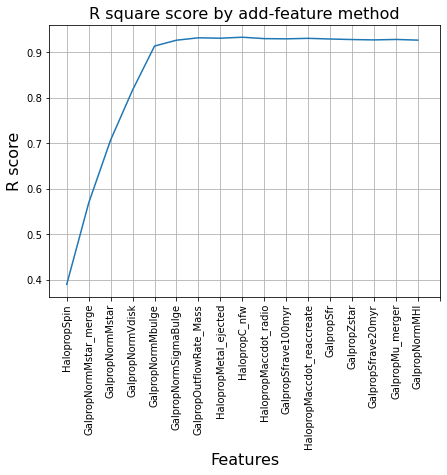

Elapsed time to run RF func on Group 1: 28766.306 seconds
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.744, test=0.711) total time=17.1min
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.895) total time=18.1min
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.927) total time=25.4min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.736, test=0.700) total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.952, test=0.894) total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.949, test=0.903) total time=   8.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.986, test=0.921) total time=  11.5s
[CV 1/3] END boo

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.743, test=0.708) total time=35.2min
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.981, test=0.923) total time=17.8min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.918) total time= 7.7min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.727, test=0.709) total time=   5.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.948, test=0.893) total time=   8.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.928) total time=   4.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.923) total time=  18.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_esti

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.718, test=0.692) total time=17.1min
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.949, test=0.887) total time=18.0min
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.894) total time=25.5min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.741, test=0.716) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.730, test=0.713) total time=  10.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.984, test=0.918) total time=   4.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.924) total time=  19.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimato

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.721, test=0.696) total time=35.2min
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.893) total time=25.5min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.742, test=0.704) total time=   5.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.954, test=0.897) total time=   8.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.921) total time=  11.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.729, test=0.715) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.752, test=0.692) total time=   9.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimato

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.743, test=0.707) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.951, test=0.891) total time=17.1min
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.891) total time=35.8min
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.919) total time= 7.7min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.742, test=0.716) total time=   5.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.946, test=0.901) total time=   3.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.898) total time=  17.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.936) total time=  22.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.735, test=0.718) total time=   5.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.893) total time=  10.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.920) total time=   5.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.931) total time=  22.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.731, test=0.692) total time=   5.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.952, test=0.915) total time=   9.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_est

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.742, test=0.709) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.946, test=0.896) total time=17.1min
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.900) total time=35.9min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.921) total time=  18.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.719, test=0.704) total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.943, test=0.887) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.894) total time=  17.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estima

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.745, test=0.711) total time=17.1min
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.949, test=0.898) total time=18.1min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.914) total time=17.8min
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.919) total time= 7.8min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.741, test=0.705) total time=  10.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.904) total time=  17.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.730, test=0.723) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

In [21]:
# this code takes ~7.9 hrs (with interuption to commute) to run when the dataset is all morphologies with ~35,000 entries
start_time = time.time()

RF_results_all = functions.target_predicting_RF_function(X=X_all, y=y_all)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on Group 1: {elapsed_time:.3f} seconds")

#### The most important features for the complete dataset are:
     1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281
	 10 HalopropMaccdot_radio 0.9303051938395659
	 11 GalpropSfrave100myr 0.9298458404970287
	 12 HalopropMaccdot_reaccreate 0.9309502132434292
	 13 GalpropSfr 0.9294737415746473
	 14 GalpropZstar 0.9282941827107841
	 15 GalpropSfrave20myr 0.9274881104697413
	 16 GalpropMu_merger 0.9284962913476585
	 17 GalpropNormMHI 0.9270127729828616

### KITP-CCA workshop presentation, Slide 5, "Which Features Matter?"

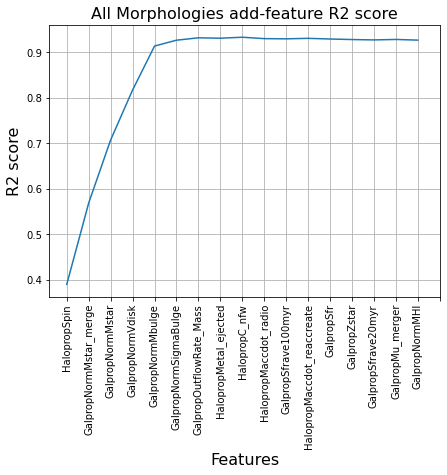

In [22]:
all_morph_fig_add_feature=RF_results_all[4].plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,18))
all_morph_fig_add_feature.set_title(label= 'All Morphologies add-feature R2 score',fontsize=16)
all_morph_fig_add_feature.set_xlabel('Features',fontsize=16)
all_morph_fig_add_feature.set_ylabel('R2 score',fontsize=16)

# all_morph_fig_add_feature.get_figure().savefig('v35_All_morphologies_R2score_by_addfeature_method.jpg', dpi=500)

plt.show()

In [24]:
# RF_results_all[4].to_csv('v35_All_morphologies_Max_R2_scores_by_addfeature_method.csv', index=False)

all_morph_addfeat = pd.read_csv('v35_All_morphologies_Max_R2_scores_by_addfeature_method.csv')

all_morph_pred_fig = RF_results_all[1]
# all_morph_pred_fig.savefig('v35_All_morphologies_RF_Prediction_vs_True.jpeg', dpi=500)
plt.show()

In [25]:
all_morph_fig_builtin_imp = RF_results_all[2]
# all_morph_fig_builtin_imp.savefig('v35_All_morphologies_Builtin_Feature_Ranking.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =4> </a> <br> Symbolic Regression (SR) Equation Search for Physical Model

### <font color='purple'> <a id =4> </a> <br> All morphologies

#### <font color='blue'> Run the Symbolic Regression algorithm to search for the best physical model in terminal or VisualStudio, running the file SR_eqn_search_all_morphologies_v1.py
Note: The SR algorithm does not run in Jupyter Notebook.

#### The pipeline for SR:
1. Randomly choose 7,000 (out of 35,000) galaxies to feed the SR search. This is because SR can use max ~10,000 entries to search for an equation.
2. Use only the most important features from the step above to feed the SR. This is because SR cannot handle a large amount of features and it does apply the built-in RF feature ranking before searching for an equation.
3. Run the SR equation search using the allowed mathematical operations for the task at hand.

Run1: The best equation found by SR when n_iter=1000 is:

sr_eqn1 = 6222.54862299952*(HalopropSpin + 0.054368068*(-2.3420465*GalpropNormMbulge/GalpropNormMstar + 2.9520118)/GalpropNormVdisk)**3

In [7]:
sr_v1_eqn1 = 6222.5*(df_normalized_31.loc[:,'HalopropSpin'] + 0.054 * (-2.34*df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar'] + 2.95)/df_normalized_31.loc[:, 'GalpropNormVdisk'])**3

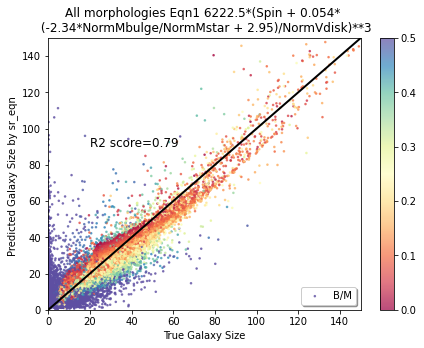

In [17]:
r2_score_all1=r2_score(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn1,
            c = df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M', vmin=0.0, vmax=0.5)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_all1), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('All morphologies Eqn1 6222.5*(Spin + 0.054* \n (-2.34*NormMbulge/NormMstar + 2.95)/NormVdisk)**3')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run1_All_morphologies_eqn_vs_true_gal_size_n_iter_1000.jpeg', dpi=500)
plt.show()

Run2: The best equation found by SR when n_iter=5000 is:

sr_eqn2 = HalopropSpin/(GalpropNormVdisk*(GalpropNormMstar_merge + 0.0010560532))

In [9]:
sr_v1_eqn2 = df_normalized_31.loc[:, 'HalopropSpin']/(df_normalized_31.loc[:, 'GalpropNormVdisk']*(df_normalized_31.loc[:, 'GalpropNormMstar_merge']+0.001))

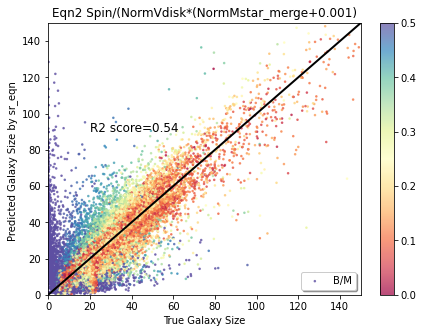

In [10]:
r2_score_all2=r2_score(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn2)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn2,
            c = df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M', vmin=0.0, vmax=0.5)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_all2), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('All morphologies \n Eqn2 Spin/(NormVdisk*(NormMstar_merge+0.001)')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run2_All_morphologies_eqn_vs_true_gal_size_n_iter_5000.jpeg', dpi=500)
plt.show()

Run3: The best equation found by SR when n_iter=15000 is:

1358.0472*HalopropSpin*exp(-2.2417495*GalpropNormMbulge/GalpropNormMstar)/GalpropNormVdisk**2

Note: For this run, I also increased the number of randomly chosen galaxies from 7,000 in the previous runs, to 9,000 galaxies for this run.

In [11]:
sr_v1_eqn3 = 1358.1*df_normalized_31.loc[:, 'HalopropSpin']*np.exp(-2.24*df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar'])/df_normalized_31.loc[:, 'GalpropNormVdisk']**2

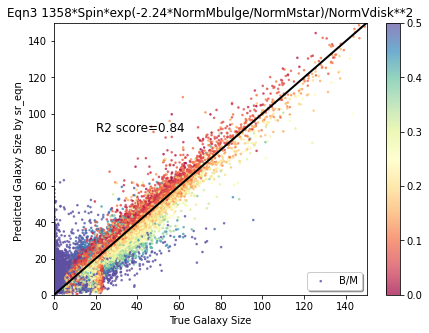

In [12]:
r2_score_all3=r2_score(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn3)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn3,
            c = df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M' , vmin=0.0, vmax=0.5)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_all3), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('All morphologies \n Eqn3 1358*Spin*exp(-2.24*NormMbulge/NormMstar)/NormVdisk**2')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run3_All_morphologies_eqn_vs_true_gal_size_n_iter_15000.jpeg', dpi=500)
plt.show()

#### <font color='darkred'> Conclusions from Run3: 1) eqn3 is a good eqn that predicts sizes well (R2=0.84), especially if ellipticals are removed 2) eqn3 is very similar to our previously obtained physical equation (see Jupyter Notebook TNG-SAM_z=0_v31) if we Taylor expan the exp term here 3) should be used in the paper to show that ellipticals can't be predicted by the eqn, hence the move to eqn search by morphology (morphology dependence clearly obvious in this plot)
    4) Repeat SR search using a) 10,000 randomly chosen galaxies (~30% of the dataset), b) fix random seed so that we do not have the random seed effect when repeating the eqn search with more iterations

Run4: The best equation found by SR when n_iter=1,000 is:

-1049.85968415349*GalpropNormMbulge*HalopropSpin/GalpropNormMstar + 1049.85968415349*HalopropSpin/GalpropNormVdisk

Elapsed time to compute the All Morphologies SR =1464.565seconds (~24min)

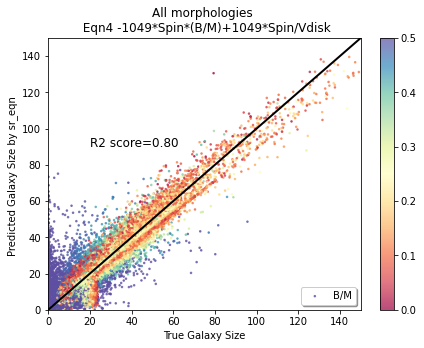

In [22]:
sr_v1_eqn4 = -1049.9*df_normalized_31.loc[:, 'HalopropSpin']*(df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']) + 1049.9*(df_normalized_31.loc[:, 'HalopropSpin']/df_normalized_31.loc[:, 'GalpropNormVdisk'])

r2_score_all4=r2_score(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn4)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn4,
            c = df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M' , vmin=0.0, vmax=0.5)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_all4), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('All morphologies \n Eqn4 -1049*Spin*(B/M)+1049*Spin/Vdisk')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run4_All_morphologies_eqn_vs_true_gal_size_n_iter_1000.jpeg', dpi=500)
plt.show()

Run5: The best equation found by SR when n_iter=5,000 is:

-1050.2404*GalpropNormMbulge*HalopropSpin/GalpropNormMstar + 1050.2404*HalopropSpin/GalpropNormVdisk

Elapsed time to compute the All Morphologies SR =6396.829seconds (~1.8 hrs)

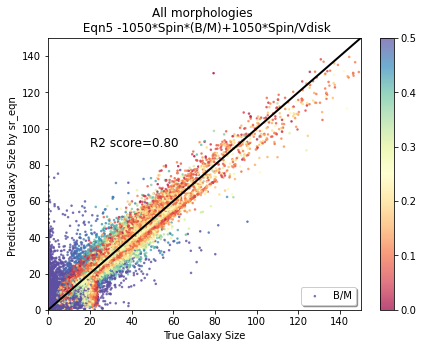

In [25]:
sr_v1_eqn5 = -1050*df_normalized_31.loc[:, 'HalopropSpin']*(df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']) + 1050*(df_normalized_31.loc[:, 'HalopropSpin']/df_normalized_31.loc[:, 'GalpropNormVdisk'])

r2_score_all5=r2_score(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn5)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn5,
            c = df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M' , vmin=0.0, vmax=0.5)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_all5), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('All morphologies \n Eqn5 -1050*Spin*(B/M)+1050*Spin/Vdisk')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run5_All_morphologies_eqn_vs_true_gal_size_n_iter_5000.jpeg', dpi=500)
plt.show()

Run6 with n_iter=10,000, everything else same as in Run4
Run6: The best equation found by SR when n_iter=10,000 is:

-1050.2532*GalpropNormMbulge*HalopropSpin/GalpropNormMstar + 1050.2532*HalopropSpin/GalpropNormVdisk

Elapsed time to compute the All Morphologies SR =13039.766seconds (~3.6 hrs)

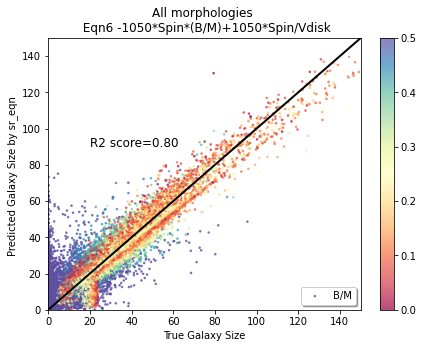

In [29]:
sr_v1_eqn6 = -1050*df_normalized_31.loc[:, 'HalopropSpin']*(df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']) + 1050*(df_normalized_31.loc[:, 'HalopropSpin']/df_normalized_31.loc[:, 'GalpropNormVdisk'])

r2_score_all6=r2_score(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn6)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn6,
            c = df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M' , vmin=0.0, vmax=0.5)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_all6), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('All morphologies \n Eqn6 -1050*Spin*(B/M)+1050*Spin/Vdisk')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run6_All_morphologies_eqn_vs_true_gal_size_n_iter_10000.jpeg', dpi=500)
plt.show()

Run7 with n_iter=1,000, everything else same as in Run4 except for including "square" among unary operators    
Run7: The best equation found by SR when n_iter=1,000 is:

1264.82447006321*HalopropSpin*(-GalpropNormMbulge/GalpropNormMstar + 0.8674587/GalpropNormVdisk)

Elapsed time to compute the All Morphologies SR =1776.980seconds (~29.6 mins)

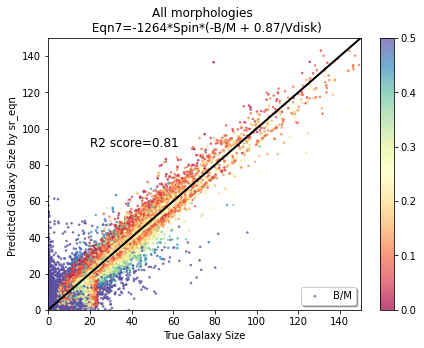

In [35]:
sr_v1_eqn7 = 1264.8*df_normalized_31.loc[:, 'HalopropSpin']*(-df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar'] + 0.87/df_normalized_31.loc[:, 'GalpropNormVdisk'])

r2_score_all7=r2_score(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn7)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn7,
            c = df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M' , vmin=0.0, vmax=0.5)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_all7), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('All morphologies \n Eqn7=-1264*Spin*(-B/M + 0.87/Vdisk)')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run7_All_morphologies_eqn_vs_true_gal_size_n_iter_1000.jpeg', dpi=500)
plt.show()

In [ ]:
Run8 - To be updated
HalopropSpin*(-1210.42157482528*GalpropNormMbulge/GalpropNormMstar - 1210.42157482528*GalpropNormVdisk + 2346.45511822163)

### KITP-CCA workshop presentation, Slide 7, "Understanding the model performance", sr_v1_eqn9 on all morphologies, color-coded by morphology to show that ellipticals cannot be predicted by the equation

Run9 with n_iter=15,000, everything same as in Run7   
Run9: The best equation found by SR when n_iter=15,000 is:

-1050.2532*GalpropNormMbulge*HalopropSpin/GalpropNormMstar + 1050.2532*HalopropSpin/GalpropNormVdisk

Elapsed time to compute the All Morphologies SR =21701.245seconds (~6 hrs)

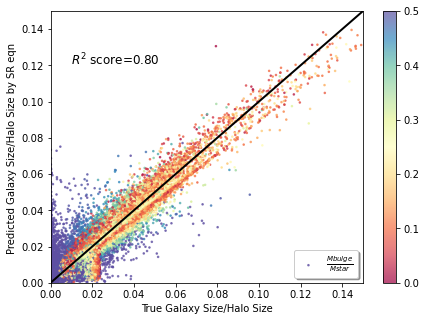

In [148]:
sr_v1_eqn9 = -1050*df_normalized_31.loc[:, 'HalopropSpin']*(df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']) + 1050*(df_normalized_31.loc[:, 'HalopropSpin']/df_normalized_31.loc[:, 'GalpropNormVdisk'])

r2_score_all9=r2_score(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn9)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_normalized_31.loc[:, 'GalpropNormHalfRadius']*1e-3, sr_v1_eqn9*1e-3,
            c = df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= r'$\frac{Mbulge}{Mstar}$' , vmin=0.0, vmax=0.5)
ax.text(10*1e-3, 120*1e-3, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_all9), size=12)
ax.plot([0.0, 150*1e-3], [0.0, 150*1e-3], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150*1e-3])
ax.set_ylim([0.0,150*1e-3])
# ax.set_title('All morphologies \n Eqn9 -1050*Spin*(B/M)+1050*Spin/Vdisk')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run9_All_morphologies_eqn_vs_true_gal_size_n_iter_15000.jpeg', dpi=500)
plt.show()

### KITP-CCA workshop presentation, Slide 6, "Understanding the model performance", sr_v1_eqn9 on all morphologies, no color coding to show that only using the machine you cannot understand the behaviour of the dataset (eg outliers, odd behaviour)

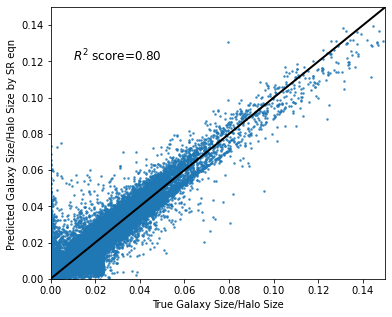

In [145]:
sr_v1_eqn9 = -1050*df_normalized_31.loc[:, 'HalopropSpin']*(df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']) + 1050*(df_normalized_31.loc[:, 'HalopropSpin']/df_normalized_31.loc[:, 'GalpropNormVdisk'])

r2_score_all9=r2_score(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn9)

fig_complete, ax = plt.subplots(figsize=(6, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_normalized_31.loc[:, 'GalpropNormHalfRadius']*1e-3, sr_v1_eqn9*1e-3,
                    s=10, marker='.', alpha=0.7)
#             c = df_normalized_31.loc[:, 'GalpropNormMbulge']/df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
#             s=10, marker='.', alpha=0.7,label= 'B/M' , vmin=0.0, vmax=0.5)
ax.text(10*1e-3, 120*1e-3, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_all9), size=12)
# ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_all9), size=12)

ax.plot([0.0, 150*1e-3], [0.0, 150*1e-3], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150*1e-3])
ax.set_ylim([0.0,150*1e-3])
# ax.set_title('All morphologies \n Eqn9 -1050*Spin*(B/M)+1050*Spin/Vdisk')
ax.set_xlabel('True Galaxy Size/Halo Size')
# ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size by SR eqn ')
# fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run9_All_galaxies_eqn_vs_true_gal_size_nocolor.jpeg', dpi=500)
plt.show()

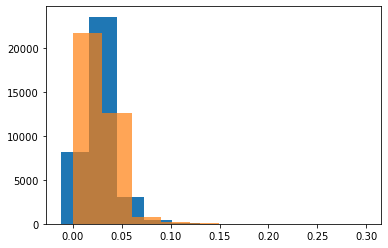

In [133]:
plt.hist(sr_v1_eqn9*1e-3)
plt.hist(df_normalized_31.loc[:, 'GalpropNormHalfRadius']*1e-3, alpha=0.7)
plt.show()

## The physical formula extracted previously: size=1.14*(Mdisk/Mstar)*(Spin/(Vdisk/Vvir)^2)*Rhalo

Note: this physical equation is returned to its dimensions and Mdisk/Mstar is used instead of Mbulge/Mstar

In [36]:
def mdiskmstar_spin_vdisk2_func(spin_vdisk_diskmstar_halo, c, spin_min):
    "' This is the SR eqn found for pure disks, spin/normVdisk^2 + modifications using human knowledge/physics insights"
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is sspin_vdisk_diskmstar_halo[0]
    # vdisk is spin_vdisk_diskmstar_halo[1]
    # Mdisk/Mstar is spin_vdisk_diskmstar_halo[2]
    # halomass is spin_vdisk_diskmstar_halo[3]
    # halorad (size of halo) is spin_vdisk_diskmstar_halo[4]
#     spin_min = 0.02
    spin_use = np.copy(spin_vdisk_diskmstar_halo[0])
    vdisk = np.copy(spin_vdisk_diskmstar_halo[1])
    diskmstar = np.copy (spin_vdisk_diskmstar_halo[2])
    halovelocity = np.copy(spin_vdisk_diskmstar_halo[3])
    halorad = np.copy(spin_vdisk_diskmstar_halo[4])


    spin_use[spin_use < spin_min] = spin_min
    
    size = (c*(diskmstar**1)*spin_use/(vdisk/halovelocity)**2) * halorad * 1000 # the 1000 factor is there to account for unit differences between Mpc (for Rhalo) and kpc (for Galaxy Halfmass Rad)

    return size

In [111]:
def disks_physical_formula_func_version4 (df, group):
    
    """ This function takes a df as an input, then: a) extracts the size, spin and vdisk columns from the df, 
    b) forms a 2,M array with the spin & vdisk columns (called spin_vdisk)
    c) does not use curve_fit but only applies given function #uses curve_fit to find the optimal parameters of spin_vdisk2_func (whose input is spin_vdisk and true size of the galaxies from the df)
    d) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on the complete dataset, df
    e) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on on the galaxies with low spin (spin<0.021)
    f) Plots the figure of the true size vs predicted size for each group of galaxy morphology (noted in the title)
    
    It returns: the spin_vdisk 2,M array, the optimal parameters and pcov from curve_fit, the size array obtained
    by applying spin_vdisk2_func on spin_vdisk with parameters obtained from curve_fit, and the
    figure comparing true size vs predicted size
    
    Note: the group input has to be in a string format"""
    
#   a)
    halovelocity=np.array(df.loc[:,'HalopropVvir'])
    halorad= np.array(df.loc[:,'GalpropRhalo'])
    
    Size_true = np.array(df.loc[:, 'GalpropHalfRadius']) 
    HalopropSpin = np.array(df.loc[:, 'HalopropSpin'])
    GalpropVdisk = np.array(df.loc[:, 'GalpropVdisk'])
#   b) 
    spin_vdisk = [HalopropSpin, GalpropVdisk]
    spin_vdisk = np.array (spin_vdisk) # convert list into array
    
    BulgeMstar = np.array (df.loc[:, 'BulgeMstar_ratio'])
    
    Mdisk = np.array (df.loc[:, 'GalpropMdisk'])
    
    DiskMstar = np.array (df.loc[:, 'DiskMstar_ratio'])
    
    spin_vdisk_diskmstar_halo = np. array([HalopropSpin, GalpropVdisk, DiskMstar, halovelocity, halorad])
    
#     spin_vdisk_diskmstar = np. array([HalopropSpin, GalpropVdisk, DiskMstar])

#     spin_vdisk_bmstar = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar])


#   c)
# use first line when spin_min is variable
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar_halo, Size_true, p0=[10, 500, 0.021])
# use second line when spin_min is fixed   
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar, Size_true, p0=[1000, 500])

# popt now from popt14 = [-0.03466038  1.1864195   0.01997989], rounded to 2 digits
    popt = [1.14, 0.021]
    size_func = mdiskmstar_spin_vdisk2_func(spin_vdisk_diskmstar_halo, *popt)
#   d) 
    r2_score_df = r2_score(Size_true, size_func)
    r2_score_df
#   e) 
    df_spin_size = df.loc[:,['GalpropHalfRadius', 'HalopropSpin']]
    df_spin_size.loc[:, "Predicted"] = size_func
    zz = df_spin_size[df_spin_size.loc[:,'HalopropSpin']<=0.021]
    actual_size= zz['GalpropHalfRadius']
    predicted_size = zz['Predicted']
    r2_score_lowspin = r2_score(actual_size, predicted_size)

#   f) Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(7, 5))
    
    ax = plt.subplot()
    im = ax.scatter(Size_true, size_func, marker='.', s=10, alpha=0.7, 
#                 c  = df.loc[:,'GalpropMdisk'],
                c  = df.loc[:,'DiskMstar_ratio'],  
                cmap='Spectral',
#                 label=' colorbar: $\frac{Mdisk}{Mstar}$ \n fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt))
                label=r' $\frac{Mdisk}{Mstar}$ ', vmin=0.0, vmax=1.0)

    ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
    ax.set_xlim([0.0,25])
    ax.set_ylim([0.0,25])
    ax.text(3, 22, r'$R^{2}$ =' + '{:.2f}'.format(r2_score_df), size=12)
#     ax.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(r2_score(actual_size, predicted_size)), size=12)
#     ax.set_title('{} - Raw Dataset \n Eqn size=1.14*Mdisk/Mstar*spin/(vdisk/vvir)^2*Rhalo vs True Size '.format(group))
    ax.set_ylabel('Size as predicted by physical model [kpc]')
    ax.set_xlabel('True Size [kpc]')
    ax.legend(loc = 'lower right', shadow=True)
    fig_prediction.colorbar(im, ax=ax)
    
    fig_prediction.tight_layout()
#     plt.savefig('PhysModel_vs_TrueSize_allmorphologies.jpeg', dpi=500)
    plt.show()
    
    return spin_vdisk_diskmstar_halo, popt, popt, size_func, fig_prediction, r2_score_df, r2_score_lowspin

#### size=1.14*Mdisk/Mstar*spin/(vdisk/vvir)^2*Rhalo on all morphologies

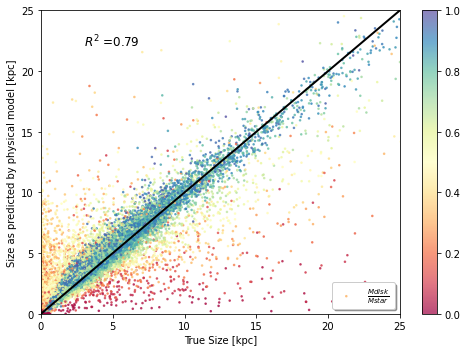

In [45]:
results_df_all = disks_physical_formula_func_version4(df_not_normalized, group = 'All morphologies')
poptall = results_df_all[1]

### KITP-CCA workshop presentation, Slide 10, "The data-driven derived physical model" (use this plot with disk-like galaxies only because the one with all morphologies has a low R2 score due to ellipticals)

#### size=1.14*Mdisk/Mstar*spin/(vdisk/vvir)^2*Rhalo on all galaxies but ellipticals (all disk-like galaxies)

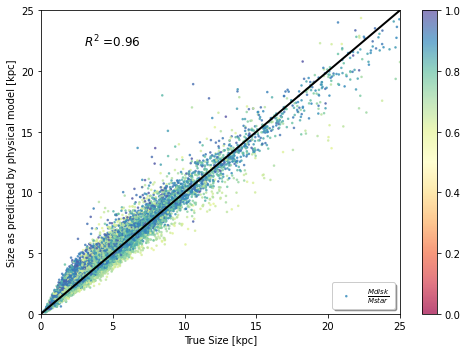

In [43]:
results_df_disklike = disks_physical_formula_func_version4(df_disklike_raw, group = 'Disklike Gals')
poptdisklike = results_df_disklike[1]

#### size = 1000*(Spin/(vdisk/vvir)^2)*Rhalo on all morphologies - Not Normalized variables

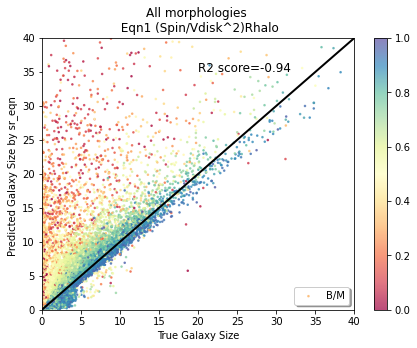

In [88]:
sr_org_eqn1 = 1000*df_not_normalized.loc[:, 'HalopropSpin']*df_not_normalized.loc[:, 'GalpropRhalo']/(df_not_normalized.loc[:, 'GalpropVdisk']/df_not_normalized.loc[:, 'HalopropVvir'])**2

r2_score_org_all1=r2_score(df_not_normalized.loc[:, 'GalpropHalfRadius'], sr_org_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_not_normalized.loc[:, 'GalpropHalfRadius'], sr_org_eqn1,
            c = df_not_normalized.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M' , vmin=0.0, vmax=1.0)
ax.text(20, 35, 'R2 score=' + '{:.2f}'.format(r2_score_org_all1), size=12)
ax.plot([0.0, 40], [0.0, 40], color = 'black', linewidth = 2)
ax.set_xlim([0.0,40])
ax.set_ylim([0.0,40])
ax.set_title('All morphologies \n Eqn1 (Spin/Vdisk^2)Rhalo')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run9_All_morphologies_eqn_vs_true_gal_size_n_iter_15000.jpeg', dpi=500)
plt.show()

#### size = 1000*(Spin/(vdisk/vvir)^2)*Rhalo on all morphologies - Normalized variables

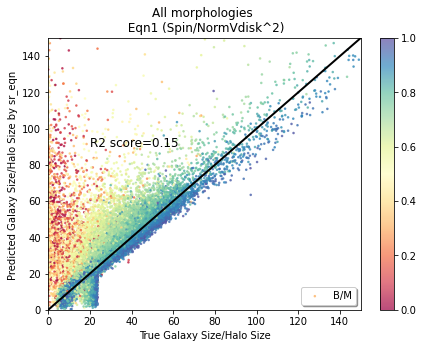

In [91]:
sr_org_eqn2 = 1000*df_normalized_31.loc[:, 'HalopropSpin']/(df_normalized_31.loc[:, 'GalpropNormVdisk'])**2

r2_score_org_all2=r2_score(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_org_eqn2)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_normalized_31.loc[:, 'GalpropNormHalfRadius'], sr_org_eqn2,
            c = df_normalized_31.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M' , vmin=0.0, vmax=1.0)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_org_all2), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('All morphologies \n Eqn1 (Spin/NormVdisk^2)')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run9_All_morphologies_eqn_vs_true_gal_size_n_iter_15000.jpeg', dpi=500)
plt.show()

#### size = 1000*(Spin/(vdisk/vvir)^2)*Rhalo on disk-likes (all galaxies but ellipticals) - Normalized variables

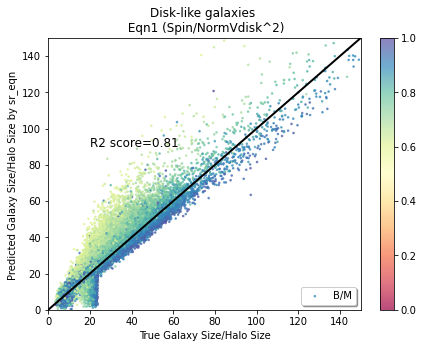

In [96]:
sr_org_eqn3 = 1000*df_disklike.loc[:, 'HalopropSpin']/(df_disklike.loc[:, 'GalpropNormVdisk'])**2

r2_score_org_all3=r2_score(df_disklike.loc[:, 'GalpropNormHalfRadius'], sr_org_eqn3)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_disklike.loc[:, 'GalpropNormHalfRadius'], sr_org_eqn3,
            c = df_disklike.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M' , vmin=0.0, vmax=1.0)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_org_all3), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('Disk-like galaxies \n Eqn1 (Spin/NormVdisk^2)')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_run9_All_morphologies_eqn_vs_true_gal_size_n_iter_15000.jpeg', dpi=500)
plt.show()

### Old physical model for pure disks, (spin/(vdisk/vvir)^2)Rhalo, using the previous function definitions 

In [260]:
def mdiskmstar_spin_vdisk2_func_v2(spin_vdisk_diskmstar_halo, c, spin_min):
    
    "'This is the original SR eqn found for pure disks: spin/normVdisk^2 - on raw dataset'"
    
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is sspin_vdisk_diskmstar_halo[0]
    # vdisk is spin_vdisk_diskmstar_halo[1]
    # Mdisk/Mstar is spin_vdisk_diskmstar_halo[2]
    # halomass is spin_vdisk_diskmstar_halo[3]
    # halorad (size of halo) is spin_vdisk_diskmstar_halo[4]
#     spin_min = 0.02
    spin_use = np.copy(spin_vdisk_diskmstar_halo[0])
    vdisk = np.copy(spin_vdisk_diskmstar_halo[1])
    diskmstar = np.copy (spin_vdisk_diskmstar_halo[2])
    halovelocity = np.copy(spin_vdisk_diskmstar_halo[3])
    halorad = np.copy(spin_vdisk_diskmstar_halo[4])


    spin_use[spin_use < spin_min] = spin_min
    
    size = (c*spin_use/(vdisk/halovelocity)**2) * halorad * 1000 # the 1000 factor is there to account for unit differences between Mpc (for Rhalo) and kpc (for Galaxy Halfmass Rad)

    return size

In [267]:
def disks_physical_formula_func_version5 (df, group):
    
    """ This function takes a df as an input, then: a) extracts the size, spin and vdisk columns from the df, 
    b) forms a 2,M array with the spin & vdisk columns (called spin_vdisk)
    c) does not use curve_fit but only applies given function #uses curve_fit to find the optimal parameters of spin_vdisk2_func (whose input is spin_vdisk and true size of the galaxies from the df)
    d) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on the complete dataset, df
    e) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on on the galaxies with low spin (spin<0.021)
    f) Plots the figure of the true size vs predicted size for each group of galaxy morphology (noted in the title)
    
    It returns: the spin_vdisk 2,M array, the optimal parameters and pcov from curve_fit, the size array obtained
    by applying spin_vdisk2_func on spin_vdisk with parameters obtained from curve_fit, and the
    figure comparing true size vs predicted size
    
    Note: the group input has to be in a string format"""
    
#   a)
    halovelocity=np.array(df.loc[:,'HalopropVvir'])
    halorad= np.array(df.loc[:,'GalpropRhalo'])
    
    Size_true = np.array(df.loc[:, 'GalpropHalfRadius']) 
    HalopropSpin = np.array(df.loc[:, 'HalopropSpin'])
    GalpropVdisk = np.array(df.loc[:, 'GalpropVdisk'])
#   b) 
    spin_vdisk = [HalopropSpin, GalpropVdisk]
    spin_vdisk = np.array (spin_vdisk) # convert list into array
    
    BulgeMstar = np.array (df.loc[:, 'BulgeMstar_ratio'])
    
    Mdisk = np.array (df.loc[:, 'GalpropMdisk'])
    
    DiskMstar = np.array (df.loc[:, 'DiskMstar_ratio'])
    
    spin_vdisk_diskmstar_halo = np. array([HalopropSpin, GalpropVdisk, DiskMstar, halovelocity, halorad])
    
#     spin_vdisk_diskmstar = np. array([HalopropSpin, GalpropVdisk, DiskMstar])

#     spin_vdisk_bmstar = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar])


#   c)
# use first line when spin_min is variable
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar_halo, Size_true, p0=[10, 500, 0.021])
# use second line when spin_min is fixed   
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar, Size_true, p0=[1000, 500])

# popt now from popt14 = [-0.03466038  1.1864195   0.01997989], rounded to 2 digits
    popt = [1.0, 0.021]
    size_func = mdiskmstar_spin_vdisk2_func_v2(spin_vdisk_diskmstar_halo, *popt)
#   d) 
    r2_score_df = r2_score(Size_true, size_func)
    r2_score_df
#   e) 
    df_spin_size = df.loc[:,['GalpropHalfRadius', 'HalopropSpin']]
    df_spin_size.loc[:, "Predicted"] = size_func
    zz = df_spin_size[df_spin_size.loc[:,'HalopropSpin']<=0.021]
    actual_size= zz['GalpropHalfRadius']
    predicted_size = zz['Predicted']
    r2_score_lowspin = r2_score(actual_size, predicted_size)

#   f) Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(7, 5))
    
    ax = plt.subplot()
    im = ax.scatter(Size_true, size_func, marker='.', s=10, alpha=0.7, 
#                 c  = df.loc[:,'GalpropMdisk'],
                c  = df.loc[:,'DiskMstar_ratio'],  
                cmap='Spectral',
#                 label=' colorbar: $\frac{Mdisk}{Mstar}$ \n fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt))
                label=r' $\frac{Mdisk}{Mstar}$ ', vmin=0.0, vmax=1.0)

    ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
    ax.set_xlim([0.0,25])
    ax.set_ylim([0.0,25])
    ax.text(3, 22, r'$R^{2}$ =' + '{:.2f}'.format(r2_score_df), size=12)
    ax.text(0.5, 20, 'R2_lowspin_gals=' + '{:.2f}'.format(r2_score(actual_size, predicted_size)), size=12)
    ax.set_title('{} - Raw Dataset \n Eqn size=spin/(vdisk/vvir)^2*Rhalo vs True Size '.format(group))
    ax.set_ylabel('Size as predicted by physical model [kpc]')
    ax.set_xlabel('True Size [kpc]')
    ax.legend(loc = 'lower right', shadow=True)
    fig_prediction.colorbar(im, ax=ax)
    
    fig_prediction.tight_layout()
#     plt.savefig('Puredisks_PhysModel_vs_TrueSize.jpeg', dpi=500)
    plt.show()
    
    return spin_vdisk_diskmstar_halo, popt, popt, size_func, fig_prediction, r2_score_df, r2_score_lowspin

#### The performance of (spin/(vdisk/vvir)^2)Rhalo on pure disk galaxies (Not Normalized variables, accounting for spin_min)

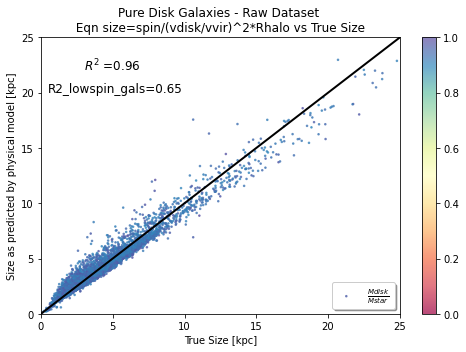

In [268]:
results_df_1_v1 = disks_physical_formula_func_version5(df_1_raw, group = 'Pure Disk Galaxies')
popt1_v1 = results_df_1_v1[1]

#### The performance of (spin/(vdisk/vvir)^2)Rhalo on disk-like galaxies (all but ellipticals) (Not Normalized variables, accounting for spin_min): The need for the Mdisk/Mstar term is obvious in this plot

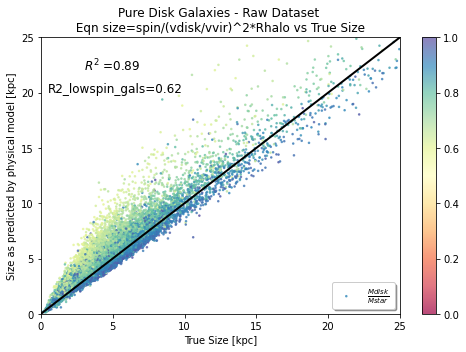

In [269]:
results_df_disklike_v1 = disks_physical_formula_func_version5(df_disklike_raw, group = 'Pure Disk Galaxies')
poptdisklike_v1 = results_df_disklike_v1[1]

### <font color='purple'> <a id =4> </a> <br> B/M <=0.1: Pure Disk galaxies only

In [93]:
# Remove elliptical galaxies
df_1 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']<=0.1]

In [94]:
# Remove elliptical galaxies from raw dataset
df_1_raw = df_not_normalized.loc[df_not_normalized.loc[:, 'BulgeMstar_ratio']<=0.1]

#### Old SR eqn for pure disk galaxies only, spin/normvdisk^2, after adjusting for small size, spin_min galaxies (introducing spin_effective variable), Not-Normalized Size & other variables (shows some more spread than the normalized version, eventhough R2 score is the same)

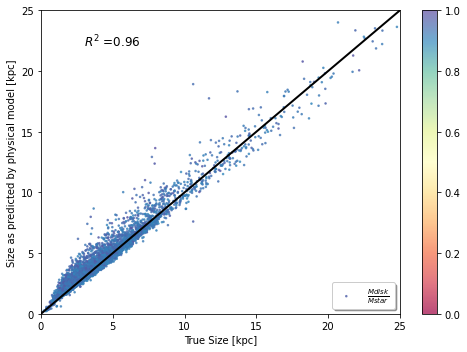

In [95]:
results_df_1 = disks_physical_formula_func_version4(df_1_raw, group = 'Pure Disk galaxies')
poptpuredisk1 = results_df_1[1]

In [173]:
def mdiskmstar_spin_vdisk2_func_v3(spin_vdisk_diskmstar, c, spin_min):
    
    "'This is the original SR eqn found for pure disks: spin/normVdisk^2 - on the normalized dataset'"
    
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is sspin_vdisk_diskmstar_halo[0]
    # vdisk is spin_vdisk_diskmstar_halo[1]
    # Mdisk/Mstar is spin_vdisk_diskmstar_halo[2]
    # halomass is spin_vdisk_diskmstar_halo[3]
    # halorad (size of halo) is spin_vdisk_diskmstar_halo[4]
#     spin_min = 0.02
    spin_use = np.copy(spin_vdisk_diskmstar[0])
    normvdisk = np.copy(spin_vdisk_diskmstar[1])
    diskmstar = np.copy (spin_vdisk_diskmstar[2])
#     halovelocity = np.copy(spin_vdisk_diskmstar_halo[3])
#     halorad = np.copy(spin_vdisk_diskmstar_halo[4])


    spin_use[spin_use < spin_min] = spin_min
    
    size = c*spin_use/(normvdisk**2) # the 1000 factor is there to account for unit differences between Mpc (for Rhalo) and kpc (for Galaxy Halfmass Rad)

    return size

In [214]:
def disks_physical_formula_func_version7 (df, group):
    
    """ This function takes a df as an input, then: a) extracts the size, spin and vdisk columns from the df, 
    b) forms a 2,M array with the spin & vdisk columns (called spin_vdisk)
    c) does not use curve_fit but only applies given function #uses curve_fit to find the optimal parameters of spin_vdisk2_func (whose input is spin_vdisk and true size of the galaxies from the df)
    d) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on the complete dataset, df
    e) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on on the galaxies with low spin (spin<0.021)
    f) Plots the figure of the true size vs predicted size for each group of galaxy morphology (noted in the title)
    
    It returns: the spin_vdisk 2,M array, the optimal parameters and pcov from curve_fit, the size array obtained
    by applying spin_vdisk2_func on spin_vdisk with parameters obtained from curve_fit, and the
    figure comparing true size vs predicted size
    
    Note: the group input has to be in a string format"""
    
#   a)
#     halovelocity=np.array(df.loc[:,'HalopropVvir'])
#     halorad= np.array(df.loc[:,'GalpropRhalo'])
    
    Size_true = np.array(df.loc[:, 'GalpropNormHalfRadius']) 
    HalopropSpin = np.array(df.loc[:, 'HalopropSpin'])
    GalpropNormVdisk = np.array(df.loc[:, 'GalpropNormVdisk'])
#   b) 
    spin_vdisk = [HalopropSpin, GalpropNormVdisk]
    spin_vdisk = np.array (spin_vdisk) # convert list into array
    
    BulgeMstar = np.array (df.loc[:, 'BulgeMstar_ratio'])
    
#     Mdisk = np.array (df.loc[:, 'GalpropMdisk'])
    
    DiskMstar = np.array (df.loc[:, 'DiskMstar_ratio'])
    
    spin_vdisk_diskmstar = np. array([HalopropSpin, GalpropNormVdisk, DiskMstar])
    
#     spin_vdisk_diskmstar = np. array([HalopropSpin, GalpropVdisk, DiskMstar])

#     spin_vdisk_bmstar = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar])


#   c)
# use first line when spin_min is variable
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar_halo, Size_true, p0=[10, 500, 0.021])
# use second line when spin_min is fixed   
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar, Size_true, p0=[1000, 500])

# popt now from popt14 = [-0.03466038  1.1864195   0.01997989], rounded to 2 digits
    popt = [1050, 0.021]
    size_func = mdiskmstar_spin_vdisk2_func_v3(spin_vdisk_diskmstar, *popt)
#   d) 
    r2_score_df = r2_score(Size_true, size_func)
    r2_score_df
#   e) 
    df_spin_size = df.loc[:,['GalpropNormHalfRadius', 'HalopropSpin']]
    df_spin_size.loc[:, "Predicted"] = size_func
    zz = df_spin_size[df_spin_size.loc[:,'HalopropSpin']<=0.021]
    actual_size= zz['GalpropNormHalfRadius']
    predicted_size = zz['Predicted']
    r2_score_lowspin = r2_score(actual_size, predicted_size)

#   f) Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(7, 5))
    
    ax = plt.subplot()
    im = ax.scatter(Size_true*1e-3, size_func*1e-3, marker='.', s=10, alpha=0.7, 
#                 c  = df.loc[:,'GalpropMdisk'],
                c  = df.loc[:,'DiskMstar_ratio'],  
                cmap='Spectral',
#                 label=' colorbar: $\frac{Mdisk}{Mstar}$ \n fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt))
                label=r' $\frac{Mdisk}{Mstar}$ ', vmin=0.0, vmax=1.0)

    ax.plot([0.0, 150*1e-3], [0.0, 150*1e-3], color = 'black', linewidth = 2)
    ax.set_xlim([0.0,150*1e-3])
    ax.set_ylim([0.0,150*1e-3])
    ax.text(30*1e-3, 120*1e-3, r'$R^{2}$ =' + '{:.2f}'.format(r2_score_df), size=12)
#     ax.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(r2_score(actual_size, predicted_size)), size=12)
#     ax.set_title('{} - Raw Dataset \n Eqn size=spin/(vdisk/vvir)^2*Rhalo vs True Size '.format(group))
    ax.set_ylabel('Predicted Galaxy Size/Halo Size by SR eqn')
    ax.set_xlabel('True Galaxy Size/Halo Size')
    ax.legend(loc = 'lower right', shadow=True)
    fig_prediction.colorbar(im, ax=ax)
    
#     fig_prediction.tight_layout()
#     plt.savefig('v35_oldSR_pure_disks_adjusting_for_spinmin.jpeg', dpi=500)
    plt.show()
    
    return spin_vdisk_diskmstar, popt, popt, size_func, fig_prediction, r2_score_df, r2_score_lowspin

### KITP-CCA workshop presentation, Slide 9, "Searching for an equation by morphology"

#### Step 1: Old SR eqn for pure disk galaxies only, spin/normvdisk^2, the very first version of the eqn , Normalized Size & other variables

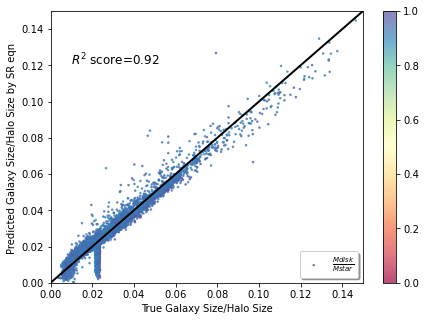

In [152]:
sr_org_eqn4 = 1050*df_1.loc[:, 'HalopropSpin']/(df_1.loc[:, 'GalpropNormVdisk'])**2

r2_score_org_all4=r2_score(df_1.loc[:, 'GalpropNormHalfRadius'], sr_org_eqn4)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_1.loc[:, 'GalpropNormHalfRadius']*1e-3, sr_org_eqn4*1e-3,
            c = df_1.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= r'$\frac{Mdisk}{Mstar}$' , vmin=0.0, vmax=1.0)
ax.text(10*1e-3, 120*1e-3, r'$ R^{2}$ score=' + '{:.2f}'.format(r2_score_org_all4), size=12)
ax.plot([0.0, 150*1e-3], [0.0, 150*1e-3], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150*1e-3])
ax.set_ylim([0.0,150*1e-3])
# ax.set_title('Pure Disk galaxies \n Eqn1 (Spin/NormVdisk^2)')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_oldSR_pure_disks.jpeg', dpi=500)
plt.show()

#### Step 2: Old SR eqn for pure disk galaxies only, spin/normvdisk^2, after adjusting for small size, spin_min galaxies (introducing spin_effective variable), Normalized Size & other variables (use this plot to compare with the one above because it also shows a tight fit - which is not the case when not-normalized size is plotted instead)

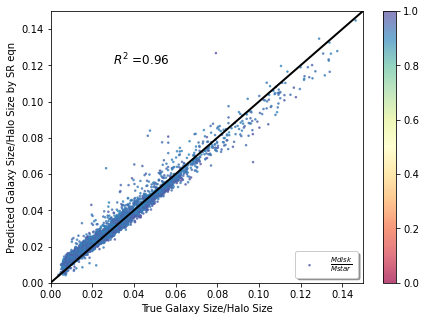

In [215]:
results_df_1_v2 = disks_physical_formula_func_version7(df_1, group = 'Pure Disk Galaxies')
popt1_v2 = results_df_1_v2[1]

----

#### Just trying how the eqn size=c*[(Mdisk/Mstar)*Spin/(vdisk/vvir)]*Rhalo works on the whole dataset, deriving it from modifying the SR-given eqn for all morphologies size=c*[(Mdisk/Mstar)+1/(vdisk/vvir)]Spin*Rhalo

In [105]:
def mdiskmstar_spin_vdisk_func(spin_vdisk_diskmstar_halo, c, spin_min):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is sspin_vdisk_diskmstar_halo[0]
    # vdisk is spin_vdisk_diskmstar_halo[1]
    # Mdisk/Mstar is spin_vdisk_diskmstar_halo[2]
    # halomass is spin_vdisk_diskmstar_halo[3]
    # halorad (size of halo) is spin_vdisk_diskmstar_halo[4]
#     spin_min = 0.02
    spin_use = np.copy(spin_vdisk_diskmstar_halo[0])
    vdisk = np.copy(spin_vdisk_diskmstar_halo[1])
    diskmstar = np.copy (spin_vdisk_diskmstar_halo[2])
    halovelocity = np.copy(spin_vdisk_diskmstar_halo[3])
    halorad = np.copy(spin_vdisk_diskmstar_halo[4])


    spin_use[spin_use < spin_min] = spin_min
    
#     size = (c*(diskmstar*spin_use) + c*spin_use/(vdisk/halovelocity)) * halorad * 1000 # the 1000 factor is there to account for unit differences between Mpc and kpc
    size = (c*(diskmstar*spin_use/(vdisk/halovelocity))) * halorad * 1000 # the 1000 factor is there to account for unit differences between Mpc and kpc

    return size

In [64]:
from scipy.optimize import curve_fit
def disks_physical_formula_func_version6 (df, group):
    
    """ This function takes a df as an input, then: a) extracts the size, spin and vdisk columns from the df, 
    b) forms a 2,M array with the spin & vdisk columns (called spin_vdisk)
    c) does not use curve_fit but only applies given function #uses curve_fit to find the optimal parameters of spin_vdisk2_func (whose input is spin_vdisk and true size of the galaxies from the df)
    d) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on the complete dataset, df
    e) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on on the galaxies with low spin (spin<0.021)
    f) Plots the figure of the true size vs predicted size for each group of galaxy morphology (noted in the title)
    
    It returns: the spin_vdisk 2,M array, the optimal parameters and pcov from curve_fit, the size array obtained
    by applying spin_vdisk2_func on spin_vdisk with parameters obtained from curve_fit, and the
    figure comparing true size vs predicted size
    
    Note: the group input has to be in a string format"""
    
#   a)
    halovelocity=np.array(df.loc[:,'HalopropVvir'])
    halorad= np.array(df.loc[:,'GalpropRhalo'])
    
    Size_true = np.array(df.loc[:, 'GalpropHalfRadius']) 
    HalopropSpin = np.array(df.loc[:, 'HalopropSpin'])
    GalpropVdisk = np.array(df.loc[:, 'GalpropVdisk'])
#   b) 
    spin_vdisk = [HalopropSpin, GalpropVdisk]
    spin_vdisk = np.array (spin_vdisk) # convert list into array
    
    BulgeMstar = np.array (df.loc[:, 'BulgeMstar_ratio'])
    
    Mdisk = np.array (df.loc[:, 'GalpropMdisk'])
    
    DiskMstar = np.array (df.loc[:, 'DiskMstar_ratio'])
    
    spin_vdisk_diskmstar_halo = np. array([HalopropSpin, GalpropVdisk, DiskMstar, halovelocity, halorad])
    
#     spin_vdisk_diskmstar = np. array([HalopropSpin, GalpropVdisk, DiskMstar])

#     spin_vdisk_bmstar = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar])


#   c)
# use first line when spin_min is variable
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar_halo, Size_true, p0=[10, 500, 0.021])
# use second line when spin_min is fixed   
    popt, pcov = curve_fit(mdiskmstar_spin_vdisk_func, spin_vdisk_diskmstar_halo, Size_true, p0=[1000, 0.02])

# popt now from popt14 = [-0.03466038  1.1864195   0.01997989], rounded to 2 digits
#     popt = [1, 0.021]
    size_func = mdiskmstar_spin_vdisk_func(spin_vdisk_diskmstar_halo, *popt)
#   d) 
    r2_score_df = r2_score(Size_true, size_func)
    r2_score_df
#   e) 
    df_spin_size = df.loc[:,['GalpropHalfRadius', 'HalopropSpin']]
    df_spin_size.loc[:, "Predicted"] = size_func
    zz = df_spin_size[df_spin_size.loc[:,'HalopropSpin']<=0.021]
    actual_size= zz['GalpropHalfRadius']
    predicted_size = zz['Predicted']
    r2_score_lowspin = r2_score(actual_size, predicted_size)

#   f) Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(7, 5))
    
    ax = plt.subplot()
    im = ax.scatter(Size_true, size_func, marker='.', s=10, alpha=0.7, 
#                 c  = df.loc[:,'GalpropMdisk'],
                c  = df.loc[:,'DiskMstar_ratio'],  
                cmap='Spectral',
#                 label=' colorbar: Mdisk/Mstar ratio \n fit: a=%5.3f \n c=%5.3f' % tuple(popt))
                label=' colorbar: Mdisk/Mstar ratio \n fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt))
    ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
    ax.set_xlim([0.0,25])
    ax.set_ylim([0.0,25])
    ax.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(r2_score_df), size=12)
    ax.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(r2_score(actual_size, predicted_size)), size=12)
    ax.set_title('{} - Raw Dataset \n Eqn size=c*[(Mdisk/Mstar)*Spin/(vdisk/vvir)]*Rhalo vs True Size '.format(group))
    ax.set_ylabel('Size as predicted by spin/vdisk^2 function [kpc]')
    ax.set_xlabel('True Size [kpc]')
    ax.legend(loc = 'lower right', shadow=True)
    fig_prediction.colorbar(im, ax=ax)
    
    fig_prediction.tight_layout()
    # plt.savefig('BulgierDisks_TrueSize_vs_FunctionSize_15_wsmallgals.jpeg', dpi=500)
    plt.show()
    
    return spin_vdisk_diskmstar_halo, popt, popt, size_func, fig_prediction, r2_score_df, r2_score_lowspin

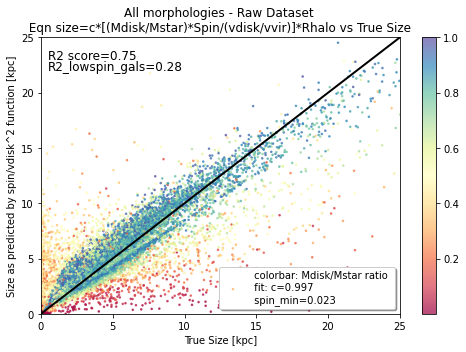

In [65]:
results_df_all_1 = disks_physical_formula_func_version6(df_not_normalized, group = 'All morphologies')
poptall_1 = results_df_all_1[1]

### <font color='purple'> <a id =4> </a> <br> B/M <=0.4: Disk like galaxies only

In [46]:
# Add column 'BulgeMstar_ratio' defined as Bulge mass/Stellar mass, to be used as a proxy for galaxy morphology
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']

In [187]:
# Remove elliptical galaxies
df_disklike = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']<=0.40]

In [35]:
# Remove elliptical galaxies from raw dataset
df_disklike_raw = df_not_normalized.loc[df_not_normalized.loc[:, 'BulgeMstar_ratio']<=0.40]

In [188]:
df_disklike.shape

(31524, 35)

In [183]:
df_normalized_31.shape

(35368, 35)

In [184]:
35368-31524

3844

In [189]:
(3844/35368)*100

10.868581768830582

Note: There are only 3844 elliptical galaxies in our dataset. That accounts for 11% of our dataset.

### <font color='purple'> <a id =4> </a> <br> B/M >0.4: Elliptical galaxies only

### Learning Curves for Ellipticals: KITP-CCA workshop presentation, Slide 13 "Do we have the information for ellipticals"

In [219]:
# Elliptical galaxies
df_ellipticals = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']>0.40]

In [220]:
df_ellipticals.shape

(3844, 35)

In [222]:
X_ellipticals = df_ellipticals.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio', 'GalpropNormMdisk', 
                                        'DiskMstar_ratio'])


y_ellipticals = df_ellipticals.loc[:,'GalpropNormHalfRadius']

#### RF

Elapsed time to run RF Learning Curves on Ellipticals: 7.997 seconds


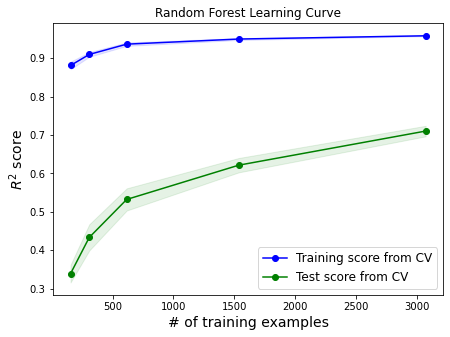

In [224]:
# this code takes ~8sec to run on the whole dataset with ~4,000 galaxies
start_time = time.time()

lc_ellipticals_rf = plot_learning_curve(best_RF, 'Random Forest Learning Curve', X_ellipticals, y_ellipticals, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('v35_LC_RF_Ellipticals.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF Learning Curves on Ellipticals: {elapsed_time:.3f} seconds")

#### Conclusion: The increasing slope of the test scores (green line) shows that we do not have enogh ellipticals in our dataset to get to a conclusion. 
Therefore, to augment the population of elliptical galaxies:
    - Add TNG300 box-based SC-SAM to our current TNG100-SAM, or
    -Use augmentation technqiues to obtain a larger population of ellipticals

#### SVR

Elapsed time to run SVR Learning Curves on Ellipticals: 5.068 seconds


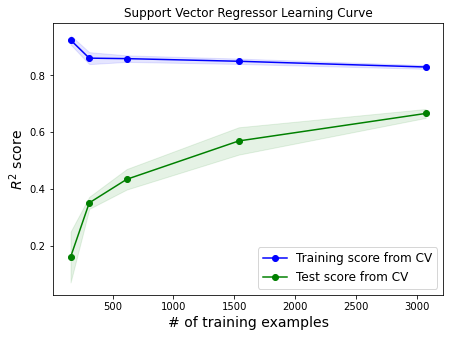

In [225]:
# this code takes ~1,2 hrs to run on the whole dataset with ~35,000 galaxies
start_time = time.time()

lc_ellipticals_svr = plot_learning_curve(best_SVR_all, 'Support Vector Regressor Learning Curve', X_ellipticals, y_ellipticals, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('v35_LC_SVR_Ellipticals.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on Ellipticals: {elapsed_time:.3f} seconds")

### <font color='purple'> <a id =4> </a> <br> Comparing our data-driven derived physical model with the ground truth, the SAM formula for galaxy sizes

### KITP-CCA workshop presentation, Slides 11 & 12, "Did we get the right answer?"

Note that for this section we use the updated TNG100-SAM (corrected for vdisk problem that the previous dataset had)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#fitting functions for MMW
def f_c(c):
    return 2.0 / 3.0 + (c / 21.5)**0.7

def f_R(lprime, md, c):
    p = -0.06 + 2.71 * md + 0.0047 / lprime;
    return (lprime/0.1)**p * (1.0-3.0*md+5.2*md*md)*(1.0-0.019*c+0.00025*c*c + 0.52/c)

def disk_infall(m_halo,r_vir,conc,spin,mstar_disk,mass_cold_gas):
    ''' disk infall'''
    if conc < 2.0: 
        conc = 2.0
    if conc > 30.0: 
        conc = 30.0
    if spin < 0.02:
        spin=0.02
    r_iso = spin*r_vir/np.sqrt(2.0)   
    mdisk = (mstar_disk + mass_cold_gas)
    fdisk = mdisk/m_halo
    fj=1.0
    if fdisk > 0.02:
        r_disk = fj*r_iso*f_R(fj*spin, fdisk, conc)/np.sqrt(f_c(conc))
    else:
        r_disk = 0.02*r_vir
    return r_disk

#### Using centrals + satellites (this is what I used for the KITP-CCA presentation, without realizing that I commented out [cent] to use only central galaxies only - late night work :())

count    57466.000000
mean         0.040382
std          0.024645
min          0.000530
25%          0.022580
50%          0.034790
75%          0.051210
max          0.304640
Name: HalopropSpin, dtype: float64
Mdisk/Mvir count    5.746600e+04
mean     4.997211e-03
std      9.431105e-03
min      1.123794e-09
25%      2.073593e-04
50%      2.318705e-03
75%      4.822610e-03
max      1.264433e-01
dtype: float64
Mdisk/MStar count    57466.000000
mean         0.802924
std          0.160983
min          0.000368
25%          0.759625
50%          0.850880
75%          0.905301
max          1.000000
dtype: float64


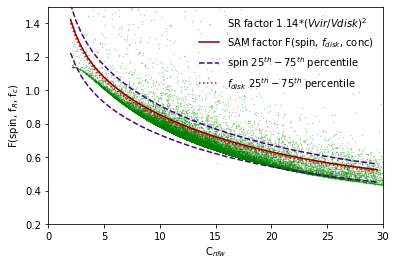

In [272]:
# if __name__=='__main__':
df = pd.read_hdf('tng100-sam.h5')
# df = df_not_normalized.loc[:, :]
# cent = df['GalpropSatType']==0
print((df['HalopropSpin']).describe())
print("Mdisk/Mvir", (df['GalpropMdisk']/df['HalopropMvir']).describe()) # fdisk values & distribution 
print("Mdisk/MStar",(df['GalpropMdisk']/df['GalpropMstar']).describe())
vvir = np.sqrt(4.3e-6 * df['HalopropMvir']/(1000*df['GalpropRhalo']))
plt.scatter(df['HalopropC_nfw'],1.14*((vvir/df['GalpropVdisk'])**2),
    alpha=0.3,marker='.',s=1, color='green', label=r'SR factor 1.14*$(Vvir/Vdisk)^2$')
cnfw = np.arange(2,30,0.5) # in order to have discrete and not continuous values of Cnfw to plot
plt.plot(cnfw,1.678*f_R(0.034,0.0021,cnfw)/np.sqrt(2*f_c(cnfw)), color='red', linestyle='dotted') #fdisk 25%  
plt.plot(cnfw,1.678*f_R(0.022,0.0023,cnfw)/np.sqrt(2*f_c(cnfw)), color='indigo',linestyle='dashed') # spin 25%
plt.plot(cnfw,1.678*f_R(0.034,0.0023,cnfw)/np.sqrt(2*f_c(cnfw)), color='darkred', label =r'SAM factor F(spin, $f_{disk}$, conc)')
plt.plot(cnfw,1.678*f_R(0.05,0.0023,cnfw)/np.sqrt(2*f_c(cnfw)), color='indigo',linestyle='dashed', label =r'spin $25^{th}-75^{th}$ percentile') # spin 75%
plt.plot(cnfw,1.678*f_R(0.034,0.0048,cnfw)/np.sqrt(2*f_c(cnfw)),color='red', linestyle='dotted', label =r'$f_{disk}$ $25^{th}-75^{th}$ percentile') #fdisk 75%

plt.xlabel('C$_{nfw}$')
plt.ylabel(r'F(spin, f$_{R}$, f$_{c}$)')
plt.xlim([0,30])
plt.ylim([0.2,1.5])
plt.legend(loc='upper right', framealpha = 0)
# plt.savefig('F_vs_Cnfw_v3_green.jpeg', dpi=500)
plt.show()

Comparison to SAM - If the size formula is size = F * spin * R_halo, this figure shows F for the SAM and our results.  The figure shows 1.14*(vvir/vdisk)^2 (green dots) compared to 1.68 (convert Rdisk to R50) * F_R(spin, fdisk, cnfw)/sqrt(2*f_c(cnfw). The dotted lines so the 25/75 range of fdisk values and the dashed lines show 25/75 range of spin values. The red line shows F for spin mean and fdisk mean.
Another question:
    I wrote the F_SAM() factor in slide 10 for people to see how complicated it is. I used colors because I find it easier to keep track of things, but let me know if that’s not ok. The question is, F_SAM() has spin in it. How come? I don’t understand how spin can be part of the F_SAM factor, but also the variable we want to isolate in spin*Rhalo term.
    Ari: I'm not sure how to answer that. Physics? There is a weak dependence in the factor. We don't get to choose the equation. The spin effects the amount of contraction of the halo which effects its circular velocity and thus the angular momentum of the disk

#### This is using only central galaxies

count    39257.000000
mean         0.039046
std          0.023135
min          0.000530
25%          0.022650
50%          0.034240
75%          0.049940
max          0.304640
Name: HalopropSpin, dtype: float64
count    39257.000000
mean         0.007164
std          0.010695
min          0.000004
25%          0.002193
50%          0.003493
75%          0.006937
max          0.126443
dtype: float64


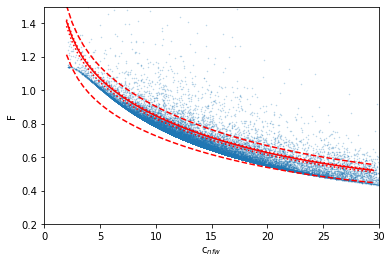

In [273]:
df = pd.read_hdf('tng100-sam.h5')
cent = df['GalpropSatType']==0
print((df['HalopropSpin'][cent]).describe())
print((df['GalpropMdisk'][cent]/df['HalopropMvir'][cent]).describe())
vvir = np.sqrt(4.3e-6 * df['HalopropMvir']/(1000*df['GalpropRhalo']))
plt.scatter(df['HalopropC_nfw'][cent],1.14*((vvir[cent]/df['GalpropVdisk'][cent])**2),
    alpha=0.3,marker='.',s=1)
cnfw = np.arange(2,30,0.5)
plt.plot(cnfw,1.678*f_R(0.034,0.0022,cnfw)/np.sqrt(2*f_c(cnfw)), color='red', linestyle='dotted')   
plt.plot(cnfw,1.678*f_R(0.022,0.0035,cnfw)/np.sqrt(2*f_c(cnfw)), color='red',linestyle='dashed')
plt.plot(cnfw,1.678*f_R(0.034,0.0035,cnfw)/np.sqrt(2*f_c(cnfw)), color='red')
plt.plot(cnfw,1.678*f_R(0.05,0.0035,cnfw)/np.sqrt(2*f_c(cnfw)), color='red',linestyle='dashed')
plt.plot(cnfw,1.678*f_R(0.034,0.007,cnfw)/np.sqrt(2*f_c(cnfw)),color='red', linestyle='dotted')

plt.xlabel('c$_{nfw}$')
plt.ylabel('F')
plt.xlim([0,30])
plt.ylim([0.2,1.5])
plt.show()

#### The same plot when using the TNG-SAM dataset that is not corrected for vdisk - note the horizontal line coming from the wrong vdisk values

count    35368.000000
mean         0.039698
std          0.023218
min          0.000530
25%          0.023240
50%          0.035030
75%          0.050783
max          0.304640
Name: HalopropSpin, dtype: float64
Mdisk/Mvir count    35368.000000
mean         0.007119
std          0.011164
min          0.000002
25%          0.001938
50%          0.003106
75%          0.006649
max          0.130526
dtype: float64
Mdisk/MStar count    35368.000000
mean         0.786345
std          0.168232
min          0.000158
25%          0.740574
50%          0.835579
75%          0.894202
max          1.000000
dtype: float64


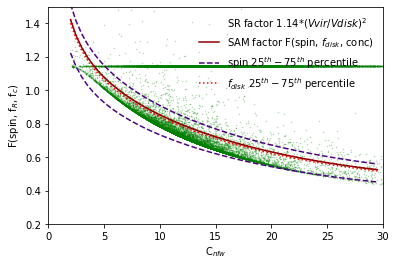

In [274]:
# df = pd.read_hdf('tng100-sam.h5')
df = df_not_normalized.loc[:, :]
# cent = df['GalpropSatType']==0
print((df['HalopropSpin']).describe())
print("Mdisk/Mvir", (df['GalpropMdisk']/df['HalopropMvir']).describe()) # fdisk values & distribution 
print("Mdisk/MStar",(df['GalpropMdisk']/df['GalpropMstar']).describe())
vvir = np.sqrt(4.3e-6 * df['HalopropMvir']/(1000*df['GalpropRhalo']))
plt.scatter(df['HalopropC_nfw'],1.14*((vvir/df['GalpropVdisk'])**2),
    alpha=0.3,marker='.',s=1, color='green', label=r'SR factor 1.14*$(Vvir/Vdisk)^2$')
cnfw = np.arange(2,30,0.5) # in order to have discrete and not continuous values of Cnfw to plot
plt.plot(cnfw,1.678*f_R(0.034,0.0021,cnfw)/np.sqrt(2*f_c(cnfw)), color='red', linestyle='dotted') #fdisk 25%  
plt.plot(cnfw,1.678*f_R(0.022,0.0023,cnfw)/np.sqrt(2*f_c(cnfw)), color='indigo',linestyle='dashed') # spin 25%
plt.plot(cnfw,1.678*f_R(0.034,0.0023,cnfw)/np.sqrt(2*f_c(cnfw)), color='darkred', label =r'SAM factor F(spin, $f_{disk}$, conc)')
plt.plot(cnfw,1.678*f_R(0.05,0.0023,cnfw)/np.sqrt(2*f_c(cnfw)), color='indigo',linestyle='dashed', label =r'spin $25^{th}-75^{th}$ percentile') # spin 75%
plt.plot(cnfw,1.678*f_R(0.034,0.0048,cnfw)/np.sqrt(2*f_c(cnfw)),color='red', linestyle='dotted', label =r'$f_{disk}$ $25^{th}-75^{th}$ percentile') #fdisk 75%

plt.xlabel('C$_{nfw}$')
plt.ylabel(r'F(spin, f$_{R}$, f$_{c}$)')
plt.xlim([0,30])
plt.ylim([0.2,1.5])
plt.legend(loc='upper right', framealpha = 0)
# plt.savefig('F_vs_Cnfw_v3_green.jpeg', dpi=500)
plt.show()

#### Conclusion: This plot shows comparison of data-driven derived physical model for sizes vs SAM sizes (where SAM Rdisk is converted into halfmass radius using the 1.68 factor) as a function of concentration. The plot shows that we recover the SAM formula using the data-driven derived physical equation. This goes into Slide 12, "Did we get the right answer?" - Yes!

In [276]:
df_not_normalized.GalpropLogMstar.describe()

count    35368.000000
mean         8.906621
std          0.802316
min          8.000039
25%          8.270805
50%          8.647157
75%          9.350378
max         11.960913
Name: GalpropLogMstar, dtype: float64

#### Physical eqn size=1.14*[(Mdisk/Mstar)*Spin/(Vdisk/Vvir)^2]*Rhalo

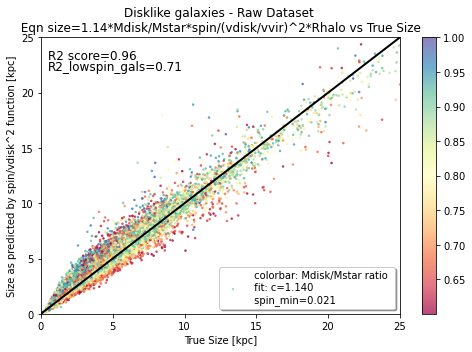

In [68]:
results_df_disklike2 = disks_physical_formula_func_version4(df_disklike_raw, group = 'Disklike galaxies')
poptdisklike2 = results_df_disklike2[1]

#### Physical eqn size=c*[(Mdisk/Mstar)*Spin/(Vdisk/Vvir)]*Rhalo

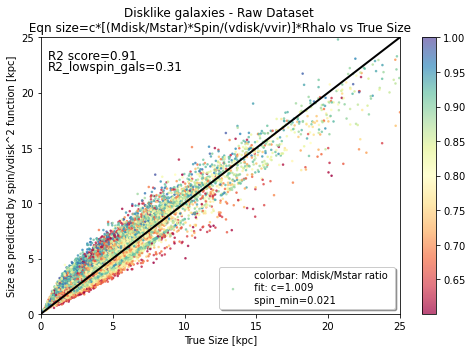

In [67]:
results_df_disklike = disks_physical_formula_func_version6(df_disklike_raw, group = 'Disklike galaxies')
poptdisklike = results_df_disklike[1]

### <font color='purple'> <a id =4> </a> <br> Compare SR generated Physical Model with True Formula

#### True SAM eqn and F_sam(), where size = F_sam()*Spin*Rhalo

In [69]:
def f_c(c):
    return 2.0 / 3.0 + (c / 21.5)**0.7

In [70]:
df_normalized_31.loc[:, 'f_c(c)'] = df_normalized_31.apply(lambda x: f_c(c=x['HalopropC_nfw']), axis=1)

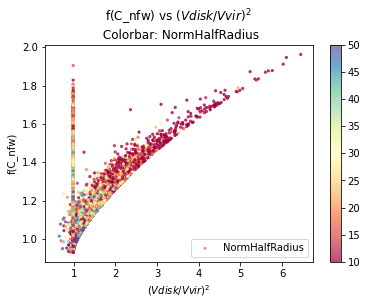

In [73]:
plt.scatter((df_normalized_31.loc[:, 'GalpropNormVdisk']**2), np.sqrt(df_normalized_31.loc[:, 'f_c(c)']),
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('f(C_nfw)')
plt.title(r'f(C_nfw) vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

In [77]:
def f_R(lprime, md, c):
    p = -0.06 + 2.71 * md + 0.0047 / lprime;
    return (lprime/0.1)**p * (1.0-3.0*md+5.2*md*md)*(1.0-0.019*c+0.00025*c*c + 0.52/c)

In [100]:
def f_R2(md, c):
    return (1.0-3.0*md+5.2*md*md)*(1.0-0.019*c+0.00025*c*c + 0.52/c)

In [ ]:
f_SAM = fj*r_iso*f_R(fj*spin, fdisk, conc)/np.sqrt(f_c(conc))

In [84]:
# everything before the Spin*Rhalo term from true SAM size formula
def f_SAM(spin, mstar_disk, mass_cold_gas, m_halo, concentration, fj=1.0):
    lprime = fj*spin
    mdisk = (mstar_disk + mass_cold_gas)
    fdisk = mdisk/m_halo
    fj=1.0
    conc = concentration
    
    func = fj*(1/np.sqrt(2.0))*f_R(fj*spin, fdisk, conc)/np.sqrt(f_c(conc))
    
    return func


In [101]:
# everything before the Spin*Rhalo term from true SAM size formula
def f_SAM2(spin, mstar_disk, mass_cold_gas, m_halo, concentration, fj=1.0):
    lprime = fj*spin
    mdisk = (mstar_disk + mass_cold_gas)
    fdisk = mdisk/m_halo
    conc = concentration
    fj=1.0
    
    func = fj*(1/np.sqrt(2.0))*f_R2(fdisk, conc)/np.sqrt(f_c(conc))
    
    return func

In [85]:
truesam_const = f_SAM(df_not_normalized.loc[:, 'HalopropSpin'], df_not_normalized.loc[:, 'GalpropMdisk'], 
                      df_not_normalized.loc[:, 'GalpropMcold'], df_not_normalized.loc[:, 'GalpropMvir'],
                     df_not_normalized.loc[:, 'HalopropC_nfw'])

In [102]:
truesam_const2 = f_SAM2(df_not_normalized.loc[:, 'HalopropSpin'], df_not_normalized.loc[:, 'GalpropMdisk'], 
                      df_not_normalized.loc[:, 'GalpropMcold'], df_not_normalized.loc[:, 'GalpropMvir'],
                     df_not_normalized.loc[:, 'HalopropC_nfw'])

#### SR generated SAM eqn and F_sr(), where size = F_sr()*Spin*Rhalo; F_sr()=1.14*(Mdisk/Mstar)*1/(Vdisk/Vvir)^2

In [95]:
# everything before the Spin*Rhalo term from Symbolic Regression geenrated physical model
def f_SR(mdiskmstar_ratio, vdisk, vvir):
    return 1.14*(mdiskmstar_ratio)*1/(vdisk/vvir)**2

In [96]:
sr_const = f_SR(df_not_normalized.loc[:, 'DiskMstar_ratio'], df_not_normalized.loc[:, 'GalpropVdisk'],
               df_not_normalized.loc[:, 'HalopropVvir'])

In [89]:
sr_const

0        0.357236
1        0.600984
2        0.980305
3        0.854810
4        0.760313
           ...   
35385    1.086599
35386    1.056235
35387    0.463210
35388    0.482469
35389    0.963478
Length: 35368, dtype: float64

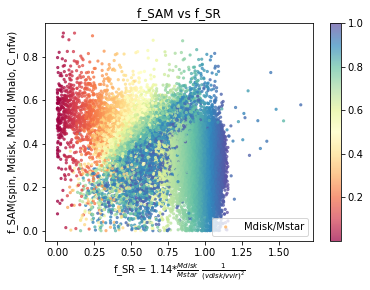

In [113]:
plt.scatter(sr_const, truesam_const,
            c = df_not_normalized.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='Mdisk/Mstar') #, vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'f_SR = 1.14*$\frac{Mdisk}{Mstar}$ $\frac{1}{(vdisk/vvir)^{2}}$')
plt.ylabel('f_SAM(spin, Mdisk, Mcold, Mhalo, C_nfw)')
plt.title(r'f_SAM vs f_SR')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('f_SAM_vs_f_SR_colorbar_MdiskMstar.jpeg', dpi=500)
plt.show()

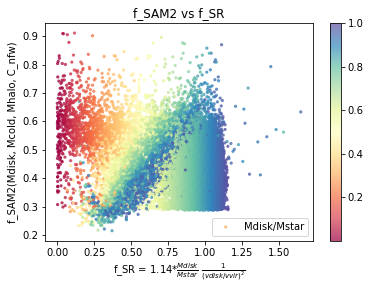

In [114]:
plt.scatter(sr_const, truesam_const2,
            c = df_not_normalized.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='Mdisk/Mstar') #, vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'f_SR = 1.14*$\frac{Mdisk}{Mstar}$ $\frac{1}{(vdisk/vvir)^{2}}$')
plt.ylabel('f_SAM2(Mdisk, Mcold, Mhalo, C_nfw)')
plt.title(r'f_SAM2 vs f_SR')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('f_SAM_vs_f_SR_colorbar_MdiskMstar_v2.jpeg', dpi=500)
plt.show()

#### <font color='blue'> Run the Symbolic Regression algorithm on Disklike galaxies to search for the best physical model (in terminal or VisualStudio), running the file SR_eqn_search_all_morphologies_v2.py

The best equation found by SR when n_iter=1000 and number of randomly chose galaxies=7,000 is:
1021.89856*Abs(HalopropSpin)**GalpropNormVdisk

In [16]:
sr_v2_eqn1 = 1021.9*np.abs(df_disklike.loc[:, 'HalopropSpin'])**df_disklike.loc[:,'GalpropNormVdisk']

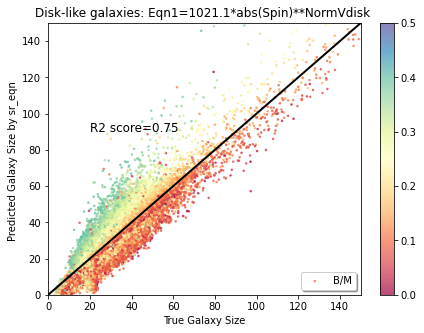

In [20]:
r2_score_disklike1=r2_score(df_disklike.loc[:, 'GalpropNormHalfRadius'], sr_v2_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_SR = ax.scatter(df_disklike.loc[:, 'GalpropNormHalfRadius'], sr_v2_eqn1,
            c = df_disklike.loc[:, 'GalpropNormMbulge']/df_disklike.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M', vmin=0.0, vmax=0.5)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disklike1), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('Disk-like galaxies: Eqn1=1021.1*abs(Spin)**NormVdisk ')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size by sr_eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('v35_SR_v2_run1_disklike_morphologies_eqn_vs_true_gal_size_n_iter_1000.jpeg', dpi=500)
plt.show()